In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

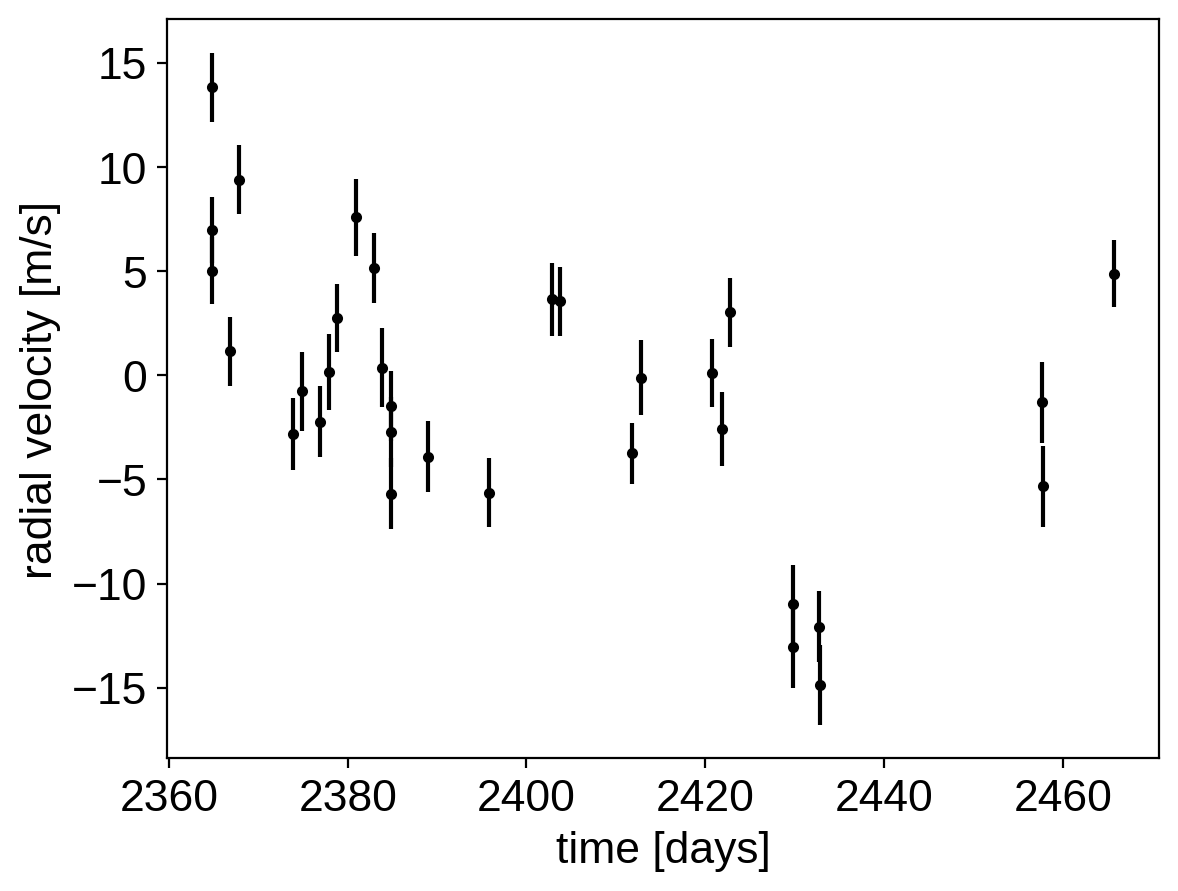

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Bound(pm.Normal, lower=0)(
        "P",
        mu=np.array(periods),
        sd=np.array(period_errs),
        shape=2,
        testval=np.array(periods),
    )

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)(
        "logK", mu=np.log(Ks), sd=10.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform(
        "ecc", shape=2, testval=np.array([0.1, 0.1])
    )
    omega = xo.distributions.Angle("omega", shape=2)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

Now, we can plot the initial model:

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


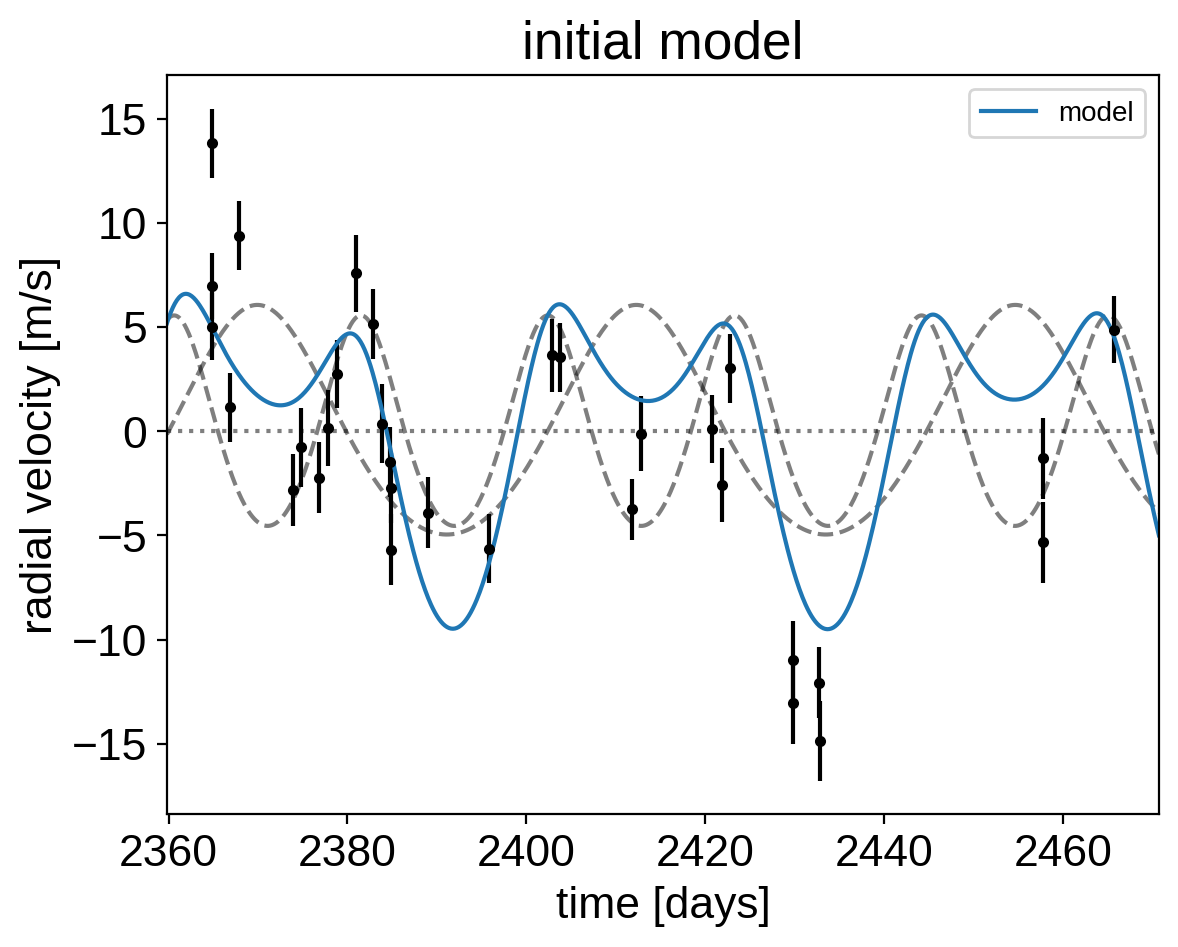

In [6]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's fit for the maximum a posterior parameters.

In [7]:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [trend]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-7.973266e+01]

1it [00:00, 582.95it/s, logp=-7.973266e+01]

2it [00:00, 715.20it/s, logp=-5.305392e+06]

3it [00:00, 747.38it/s, logp=-7.966783e+01]

4it [00:00, 726.76it/s, logp=-7.953812e+01]

5it [00:00, 800.62it/s, logp=-7.904438e+01]

6it [00:00, 842.34it/s, logp=-7.747076e+01]

7it [00:00, 816.65it/s, logp=-7.344108e+01]

8it [00:00, 811.30it/s, logp=-6.722892e+01]

9it [00:00, 801.17it/s, logp=-6.484820e+01]

10it [00:00, 817.41it/s, logp=-6.484820e+01]

11it [00:00, 812.06it/s, logp=-6.484820e+01]

12it [00:03,  3.43it/s, logp=-6.484820e+01] 


message: Optimization terminated successfully.
logp: -79.73266285618837 -> -64.8482026233154


optimizing logp for variables: [trend, logs, omega, ecc, logK, P, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.484820e+01]

1it [00:00, 445.97it/s, logp=-6.484820e+01]

2it [00:00, 513.10it/s, logp=-4.990134e+09]

3it [00:00, 590.97it/s, logp=-6.484832e+01]

4it [00:00, 637.14it/s, logp=-6.484777e+01]

5it [00:00, 644.86it/s, logp=-6.519268e+01]

6it [00:00, 667.90it/s, logp=-6.484777e+01]

7it [00:00, 668.80it/s, logp=-6.484777e+01]

8it [00:00, 692.94it/s, logp=-6.484776e+01]

9it [00:00, 714.15it/s, logp=-6.484774e+01]

10it [00:00, 733.04it/s, logp=-6.484767e+01]

11it [00:00, 732.58it/s, logp=-6.484739e+01]

12it [00:00, 712.51it/s, logp=-6.484633e+01]

13it [00:00, 716.56it/s, logp=-6.484353e+01]

14it [00:00, 733.58it/s, logp=-6.483426e+01]

15it [00:00, 737.21it/s, logp=-6.481055e+01]

16it [00:00, 729.81it/s, logp=-6.472940e+01]

17it [00:00, 726.39it/s, logp=-6.451928e+01]

18it [00:00, 634.40it/s, logp=-6.371170e+01]

19it [00:00, 643.60it/s, logp=-6.096678e+01]

20it [00:00, 649.81it/s, logp=-5.708652e+01]

21it [00:00, 645.81it/s, logp=-5.027536e+01]

22it [00:00, 652.63it/s, logp=-2.386569e+02]

23it [00:00, 662.91it/s, logp=-4.912172e+01]

24it [00:00, 659.22it/s, logp=-4.707357e+01]

25it [00:00, 666.22it/s, logp=-4.319328e+01]

26it [00:00, 672.95it/s, logp=-3.608487e+01]

27it [00:00, 671.37it/s, logp=-2.498567e+01]

28it [00:00, 669.27it/s, logp=-2.442071e+01]

29it [00:00, 675.50it/s, logp=-2.333036e+01]

30it [00:00, 680.69it/s, logp=-2.011091e+01]

31it [00:00, 685.80it/s, logp=-1.751350e+01]

32it [00:00, 690.06it/s, logp=-1.714559e+01]

33it [00:00, 694.87it/s, logp=-1.693796e+01]

34it [00:00, 699.32it/s, logp=-1.684943e+01]

35it [00:00, 702.56it/s, logp=-1.676095e+01]

36it [00:00, 692.22it/s, logp=-1.673569e+01]

37it [00:00, 694.17it/s, logp=-1.672214e+01]

38it [00:00, 696.30it/s, logp=-1.670758e+01]

39it [00:00, 695.56it/s, logp=-1.668064e+01]

40it [00:00, 697.83it/s, logp=-1.662858e+01]

41it [00:00, 701.76it/s, logp=-1.658057e+01]

42it [00:00, 705.89it/s, logp=-1.655728e+01]

43it [00:00, 702.26it/s, logp=-1.662929e+01]

44it [00:00, 707.04it/s, logp=-1.647872e+01]

45it [00:00, 710.69it/s, logp=-1.635178e+01]

46it [00:00, 714.01it/s, logp=-1.613280e+01]

47it [00:00, 713.52it/s, logp=-1.577352e+01]

48it [00:00, 715.55it/s, logp=-1.525205e+01]

49it [00:00, 715.33it/s, logp=-1.849866e+01]

50it [00:00, 719.23it/s, logp=-1.514689e+01]

51it [00:00, 719.97it/s, logp=-1.501721e+01]

52it [00:00, 716.65it/s, logp=-1.496658e+01]

53it [00:00, 716.93it/s, logp=-1.495457e+01]

54it [00:00, 719.23it/s, logp=-1.494704e+01]

55it [00:00, 720.56it/s, logp=-1.494509e+01]

56it [00:00, 717.77it/s, logp=-1.494181e+01]

57it [00:00, 719.47it/s, logp=-1.493619e+01]

58it [00:00, 721.59it/s, logp=-1.492655e+01]

59it [00:00, 722.48it/s, logp=-1.491151e+01]

60it [00:00, 720.35it/s, logp=-1.489345e+01]

61it [00:00, 721.18it/s, logp=-1.486580e+01]

62it [00:00, 721.86it/s, logp=-1.483881e+01]

63it [00:00, 723.05it/s, logp=-1.479783e+01]

64it [00:00, 723.34it/s, logp=-1.475796e+01]

65it [00:00, 725.25it/s, logp=-1.470223e+01]

66it [00:00, 727.50it/s, logp=-1.466582e+01]

67it [00:00, 730.53it/s, logp=-1.465792e+01]

68it [00:00, 731.64it/s, logp=-1.460984e+01]

69it [00:00, 727.07it/s, logp=-1.453216e+01]

70it [00:00, 728.05it/s, logp=-1.441151e+01]

71it [00:00, 728.81it/s, logp=-1.431231e+01]

72it [00:00, 729.41it/s, logp=-1.436814e+01]

73it [00:00, 730.10it/s, logp=-1.429691e+01]

74it [00:00, 736.48it/s, logp=-1.429691e+01]

74it [00:00, 736.48it/s, logp=-1.428195e+01]

75it [00:00, 736.48it/s, logp=-1.427769e+01]

76it [00:00, 736.48it/s, logp=-1.427703e+01]

77it [00:00, 736.48it/s, logp=-1.427688e+01]

78it [00:00, 736.48it/s, logp=-1.427678e+01]

79it [00:00, 736.48it/s, logp=-1.427677e+01]

80it [00:00, 736.48it/s, logp=-1.427676e+01]

81it [00:00, 736.48it/s, logp=-1.427676e+01]

82it [00:00, 736.48it/s, logp=-1.427676e+01]

83it [00:00, 736.48it/s, logp=-1.427676e+01]

84it [00:00, 736.48it/s, logp=-1.427676e+01]

85it [00:00, 736.48it/s, logp=-1.427676e+01]

86it [00:00, 736.48it/s, logp=-1.427676e+01]

87it [00:00, 736.48it/s, logp=-1.427676e+01]

88it [00:00, 736.48it/s, logp=-1.427676e+01]

89it [00:00, 736.48it/s, logp=-1.427676e+01]

90it [00:00, 736.48it/s, logp=-1.427676e+01]

91it [00:00, 736.48it/s, logp=-1.427676e+01]

92it [00:00, 736.48it/s, logp=-1.427676e+01]

93it [00:00, 736.48it/s, logp=-1.427676e+01]

94it [00:00, 736.48it/s, logp=-1.427676e+01]

95it [00:00, 736.48it/s, logp=-1.427676e+01]

96it [00:00, 736.48it/s, logp=-1.427676e+01]

97it [00:00, 736.48it/s, logp=-1.427676e+01]

98it [00:00, 736.48it/s, logp=-1.427676e+01]

99it [00:00, 736.48it/s, logp=-1.427676e+01]

100it [00:00, 736.48it/s, logp=-1.427676e+01]

101it [00:00, 736.48it/s, logp=-1.427676e+01]

102it [00:00, 736.48it/s, logp=-1.427676e+01]

103it [00:00, 736.48it/s, logp=-1.427676e+01]

104it [00:00, 736.48it/s, logp=-1.427676e+01]

105it [00:00, 736.48it/s, logp=-1.427676e+01]

106it [00:00, 736.48it/s, logp=-1.427676e+01]

107it [00:00, 736.48it/s, logp=-1.427676e+01]

108it [00:00, 736.48it/s, logp=-1.427676e+01]

109it [00:00, 736.48it/s, logp=-1.427676e+01]

110it [00:00, 736.48it/s, logp=-1.427676e+01]

111it [00:00, 736.48it/s, logp=-1.427676e+01]

112it [00:00, 736.48it/s, logp=-1.427676e+01]

113it [00:00, 736.48it/s, logp=-1.427676e+01]

114it [00:00, 736.48it/s, logp=-1.427676e+01]

115it [00:00, 736.48it/s, logp=-1.427676e+01]

116it [00:00, 736.48it/s, logp=-1.427676e+01]

117it [00:00, 736.48it/s, logp=-1.427676e+01]

118it [00:00, 736.48it/s, logp=-1.427676e+01]

119it [00:00, 736.48it/s, logp=-1.427676e+01]

120it [00:00, 736.48it/s, logp=-1.427676e+01]

121it [00:00, 736.48it/s, logp=-1.427676e+01]

122it [00:00, 736.48it/s, logp=-1.427676e+01]

123it [00:00, 736.48it/s, logp=-1.427676e+01]

124it [00:00, 736.48it/s, logp=-1.427676e+01]

125it [00:00, 736.48it/s, logp=-1.427676e+01]

126it [00:00, 736.48it/s, logp=-1.427676e+01]

127it [00:00, 736.48it/s, logp=-1.427676e+01]

128it [00:00, 736.48it/s, logp=-1.427676e+01]

129it [00:00, 736.48it/s, logp=-1.427676e+01]

130it [00:00, 736.48it/s, logp=-1.427676e+01]

131it [00:00, 736.48it/s, logp=-1.427676e+01]

132it [00:00, 736.48it/s, logp=-1.427676e+01]

133it [00:00, 736.48it/s, logp=-1.427676e+01]

134it [00:00, 736.48it/s, logp=-1.427676e+01]

135it [00:00, 736.48it/s, logp=-1.427676e+01]

136it [00:00, 736.48it/s, logp=-1.427676e+01]

137it [00:00, 736.48it/s, logp=-1.427676e+01]

138it [00:00, 736.48it/s, logp=-1.427676e+01]

139it [00:00, 736.48it/s, logp=-1.427676e+01]

140it [00:00, 736.48it/s, logp=-1.427676e+01]

141it [00:00, 736.48it/s, logp=-1.427676e+01]

142it [00:00, 736.48it/s, logp=-1.427676e+01]

143it [00:00, 736.48it/s, logp=-1.427676e+01]

144it [00:00, 736.48it/s, logp=-1.427676e+01]

145it [00:00, 727.25it/s, logp=-1.427676e+01]

145it [00:00, 727.25it/s, logp=-1.427676e+01]

146it [00:00, 727.25it/s, logp=-1.427676e+01]

147it [00:00, 727.25it/s, logp=-1.427676e+01]

148it [00:00, 727.25it/s, logp=-1.427676e+01]

149it [00:00, 727.25it/s, logp=-1.427676e+01]

150it [00:00, 727.25it/s, logp=-1.427676e+01]

151it [00:00, 727.25it/s, logp=-1.427676e+01]

152it [00:00, 727.25it/s, logp=-1.427676e+01]

153it [00:00, 727.25it/s, logp=-1.427676e+01]

154it [00:00, 727.25it/s, logp=-1.427676e+01]

155it [00:00, 727.25it/s, logp=-1.427676e+01]

156it [00:00, 727.25it/s, logp=-1.427676e+01]

157it [00:00, 727.25it/s, logp=-1.427676e+01]

158it [00:00, 727.25it/s, logp=-1.427676e+01]

159it [00:00, 727.25it/s, logp=-1.427676e+01]

160it [00:00, 727.25it/s, logp=-1.427676e+01]

161it [00:00, 727.25it/s, logp=-1.427676e+01]

162it [00:00, 727.25it/s, logp=-1.427676e+01]

163it [00:00, 727.25it/s, logp=-1.427676e+01]

164it [00:00, 727.25it/s, logp=-1.427676e+01]

165it [00:00, 727.25it/s, logp=-1.427676e+01]

166it [00:00, 727.25it/s, logp=-1.427676e+01]

167it [00:00, 727.25it/s, logp=-1.427676e+01]

168it [00:00, 727.25it/s, logp=-1.427676e+01]

169it [00:00, 727.25it/s, logp=-1.427676e+01]

170it [00:00, 727.25it/s, logp=-1.427676e+01]

171it [00:00, 727.25it/s, logp=-1.427676e+01]

172it [00:00, 727.25it/s, logp=-1.427676e+01]

173it [00:00, 727.25it/s, logp=-1.427676e+01]

174it [00:00, 727.25it/s, logp=-1.427676e+01]

175it [00:00, 727.25it/s, logp=-1.427676e+01]

176it [00:00, 727.25it/s, logp=-1.427676e+01]

177it [00:00, 727.25it/s, logp=-1.427676e+01]

178it [00:00, 727.25it/s, logp=-1.427676e+01]

179it [00:00, 727.25it/s, logp=-1.427676e+01]

180it [00:00, 293.47it/s, logp=-1.427676e+01]


message: Desired error not necessarily achieved due to precision loss.
logp: -64.8482026233154 -> -14.276760262380833


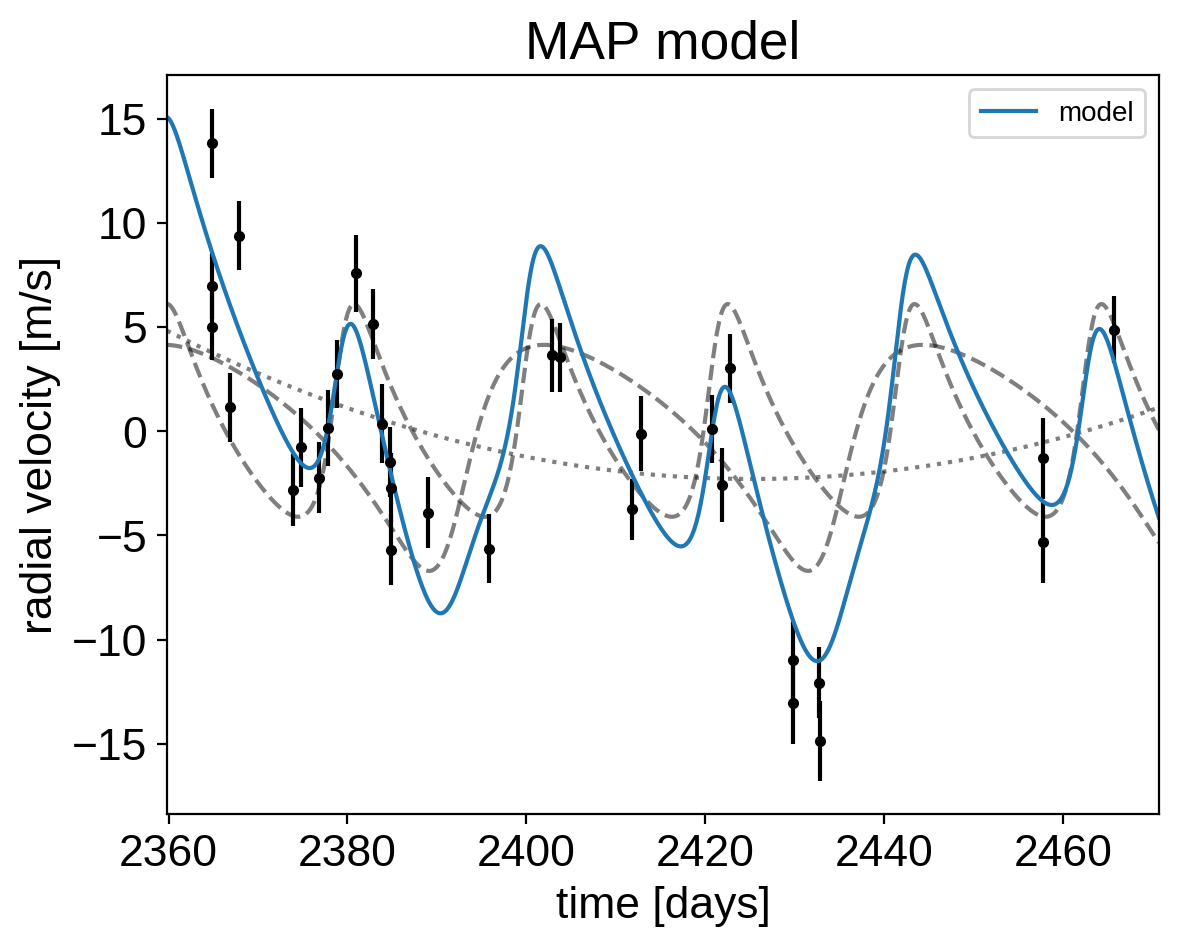

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :func:`exoplanet.get_dense_nuts_step` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [9]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.95),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 2 chains, 0 divergences:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 10/16000 [00:00<02:44, 97.34draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/16000 [00:00<06:22, 41.75draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/16000 [00:00<08:08, 32.70draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/16000 [00:00<09:07, 29.17draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/16000 [00:00<09:48, 27.13draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/16000 [00:00<10:18, 25.84draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 33/16000 [00:01<10:34, 25.16draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 37/16000 [00:01<10:46, 24.69draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 41/16000 [00:01<11:03, 24.07draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 45/16000 [00:01<11:09, 23.84draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 49/16000 [00:01<11:06, 23.94draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 52/16000 [00:01<10:30, 25.29draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/16000 [00:02<11:21, 23.38draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 58/16000 [00:02<11:01, 24.11draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 61/16000 [00:02<11:26, 23.23draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 64/16000 [00:02<11:50, 22.44draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 67/16000 [00:02<11:42, 22.69draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 70/16000 [00:02<12:01, 22.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 73/16000 [00:02<11:18, 23.48draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 76/16000 [00:03<12:13, 21.72draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 80/16000 [00:03<12:03, 22.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 84/16000 [00:03<11:41, 22.70draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 87/16000 [00:03<10:52, 24.38draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 90/16000 [00:03<11:31, 23.00draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 93/16000 [00:03<11:10, 23.72draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 96/16000 [00:03<11:12, 23.64draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 99/16000 [00:03<11:39, 22.74draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/16000 [00:04<11:13, 23.59draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 105/16000 [00:04<11:52, 22.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 108/16000 [00:04<11:01, 24.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 111/16000 [00:04<11:47, 22.45draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 115/16000 [00:04<11:34, 22.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 118/16000 [00:04<10:48, 24.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 121/16000 [00:04<11:32, 22.92draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 124/16000 [00:05<10:53, 24.31draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 127/16000 [00:05<11:43, 22.55draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 131/16000 [00:05<11:36, 22.80draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/16000 [00:05<11:09, 23.70draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 137/16000 [00:05<11:38, 22.71draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/16000 [00:05<11:07, 23.77draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 143/16000 [00:05<12:00, 22.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 146/16000 [00:06<11:08, 23.70draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 149/16000 [00:06<11:59, 22.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 153/16000 [00:06<11:37, 22.70draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 156/16000 [00:06<10:52, 24.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 159/16000 [00:06<11:35, 22.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 162/16000 [00:06<10:59, 24.03draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 165/16000 [00:06<11:41, 22.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 168/16000 [00:06<11:05, 23.79draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 171/16000 [00:07<11:37, 22.68draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 174/16000 [00:07<11:04, 23.82draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 177/16000 [00:07<12:17, 21.45draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 181/16000 [00:07<12:00, 21.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 184/16000 [00:07<11:18, 23.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 187/16000 [00:07<11:50, 22.27draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 190/16000 [00:07<11:26, 23.02draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 193/16000 [00:08<11:43, 22.47draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 196/16000 [00:08<11:28, 22.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 199/16000 [00:08<11:47, 22.33draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 202/16000 [00:08<11:34, 22.75draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 205/16000 [00:08<11:29, 22.89draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 208/16000 [00:08<11:52, 22.17draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 211/16000 [00:08<11:26, 23.00draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 214/16000 [00:09<11:58, 21.97draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 217/16000 [00:09<11:20, 23.21draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 220/16000 [00:09<11:57, 21.99draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 223/16000 [00:09<11:49, 22.23draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 226/16000 [00:09<12:17, 21.39draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 229/16000 [00:09<11:23, 23.07draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 232/16000 [00:09<11:57, 21.96draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 235/16000 [00:09<11:01, 23.85draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 238/16000 [00:10<11:57, 21.96draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 242/16000 [00:10<11:45, 22.33draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 246/16000 [00:10<11:34, 22.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 250/16000 [00:10<11:24, 23.02draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 253/16000 [00:10<10:36, 24.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 256/16000 [00:10<11:35, 22.63draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 260/16000 [00:11<11:32, 22.71draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 264/16000 [00:11<11:32, 22.72draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 268/16000 [00:11<11:31, 22.74draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 272/16000 [00:11<11:36, 22.57draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 275/16000 [00:11<11:13, 23.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 278/16000 [00:11<11:42, 22.40draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/16000 [00:11<11:22, 23.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 284/16000 [00:12<11:34, 22.62draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 287/16000 [00:12<11:18, 23.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 290/16000 [00:12<11:29, 22.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 293/16000 [00:12<11:24, 22.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 296/16000 [00:12<11:27, 22.83draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 299/16000 [00:12<11:15, 23.25draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 302/16000 [00:12<11:19, 23.10draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 305/16000 [00:12<11:23, 22.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 308/16000 [00:13<11:19, 23.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 311/16000 [00:13<11:28, 22.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 314/16000 [00:13<11:28, 22.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 317/16000 [00:13<11:20, 23.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 320/16000 [00:13<11:39, 22.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 323/16000 [00:13<11:10, 23.40draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 326/16000 [00:13<11:27, 22.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 329/16000 [00:14<11:02, 23.65draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 332/16000 [00:14<11:39, 22.41draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 335/16000 [00:14<10:58, 23.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 338/16000 [00:14<11:46, 22.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 342/16000 [00:14<11:44, 22.23draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 345/16000 [00:14<11:14, 23.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 348/16000 [00:14<11:51, 22.00draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 351/16000 [00:14<11:02, 23.62draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 354/16000 [00:15<11:58, 21.76draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 358/16000 [00:15<11:40, 22.32draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 362/16000 [00:15<11:24, 22.83draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 365/16000 [00:15<10:45, 24.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 368/16000 [00:15<11:17, 23.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 371/16000 [00:15<11:07, 23.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 374/16000 [00:15<11:09, 23.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 377/16000 [00:16<11:16, 23.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 380/16000 [00:16<11:08, 23.38draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 383/16000 [00:16<10:57, 23.74draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 386/16000 [00:16<10:29, 24.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 389/16000 [00:16<11:01, 23.60draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 392/16000 [00:16<11:11, 23.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 395/16000 [00:16<11:04, 23.49draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 398/16000 [00:17<11:13, 23.17draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 401/16000 [00:17<10:41, 24.32draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 404/16000 [00:17<13:34, 19.14draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 407/16000 [00:17<15:12, 17.08draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 409/16000 [00:17<14:44, 17.63draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 414/16000 [00:17<13:35, 19.11draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 417/16000 [00:18<13:19, 19.50draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 421/16000 [00:18<11:39, 22.28draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 425/16000 [00:18<10:44, 24.17draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 428/16000 [00:18<10:21, 25.06draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 431/16000 [00:18<10:02, 25.82draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 437/16000 [00:18<08:50, 29.34draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 443/16000 [00:18<07:38, 33.94draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 447/16000 [00:18<07:31, 34.44draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 458/16000 [00:18<05:58, 43.38draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 466/16000 [00:19<05:09, 50.14draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 473/16000 [00:19<05:22, 48.18draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 479/16000 [00:19<05:19, 48.63draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 489/16000 [00:19<04:32, 57.02draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 498/16000 [00:19<04:04, 63.28draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 506/16000 [00:19<03:52, 66.56draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 515/16000 [00:19<03:41, 69.98draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 524/16000 [00:19<03:26, 74.83draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 533/16000 [00:19<03:16, 78.70draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 542/16000 [00:20<03:18, 77.78draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 551/16000 [00:20<04:20, 59.41draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 559/16000 [00:20<04:05, 62.99draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 567/16000 [00:20<03:55, 65.46draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 577/16000 [00:20<03:31, 72.84draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 585/16000 [00:20<03:26, 74.59draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 593/16000 [00:20<03:23, 75.75draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 603/16000 [00:20<03:09, 81.06draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 614/16000 [00:21<02:58, 86.38draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 625/16000 [00:21<02:48, 91.26draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 638/16000 [00:21<02:34, 99.21draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 649/16000 [00:21<02:48, 91.36draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 659/16000 [00:21<03:12, 79.63draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 668/16000 [00:21<03:15, 78.37draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 677/16000 [00:21<03:39, 69.94draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 686/16000 [00:21<03:27, 73.71draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 696/16000 [00:22<03:12, 79.31draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 706/16000 [00:22<03:03, 83.30draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 719/16000 [00:22<02:45, 92.48draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 729/16000 [00:22<02:41, 94.30draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 740/16000 [00:22<02:34, 98.49draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 753/16000 [00:22<02:24, 105.85draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 764/16000 [00:22<02:30, 101.18draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 775/16000 [00:22<02:28, 102.81draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 786/16000 [00:22<02:30, 100.96draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 798/16000 [00:23<02:27, 103.22draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 809/16000 [00:23<02:31, 100.53draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 820/16000 [00:23<02:34, 97.95draws/s] 

Sampling 2 chains, 0 divergences:   5%|▌         | 831/16000 [00:23<02:31, 99.99draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 842/16000 [00:23<02:45, 91.46draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 852/16000 [00:23<02:42, 93.40draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 865/16000 [00:23<02:31, 99.96draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 876/16000 [00:23<02:30, 100.49draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 888/16000 [00:23<02:25, 103.56draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 902/16000 [00:24<02:14, 112.10draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 917/16000 [00:24<02:04, 120.71draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 932/16000 [00:24<02:00, 125.01draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 945/16000 [00:24<02:01, 123.85draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 958/16000 [00:24<02:10, 115.36draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 970/16000 [00:24<02:41, 93.30draws/s] 

Sampling 2 chains, 0 divergences:   6%|▌         | 981/16000 [00:24<02:40, 93.34draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 991/16000 [00:24<02:43, 91.63draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1003/16000 [00:25<02:36, 95.67draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1014/16000 [00:25<02:34, 97.27draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1026/16000 [00:25<02:28, 100.64draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1037/16000 [00:25<02:25, 103.19draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1048/16000 [00:25<02:23, 104.22draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1059/16000 [00:25<02:22, 105.12draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1070/16000 [00:25<02:31, 98.64draws/s] 

Sampling 2 chains, 0 divergences:   7%|▋         | 1081/16000 [00:25<02:27, 101.11draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1092/16000 [00:25<02:29, 99.51draws/s] 

Sampling 2 chains, 0 divergences:   7%|▋         | 1103/16000 [00:26<02:25, 102.17draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1114/16000 [00:26<02:22, 104.39draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1125/16000 [00:26<02:25, 102.41draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1136/16000 [00:26<02:43, 90.77draws/s] 

Sampling 2 chains, 0 divergences:   7%|▋         | 1146/16000 [00:26<02:52, 86.29draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1156/16000 [00:26<02:47, 88.52draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1169/16000 [00:26<02:34, 96.19draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1183/16000 [00:26<02:22, 104.29draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1195/16000 [00:26<02:17, 107.46draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1209/16000 [00:27<02:09, 114.43draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1223/16000 [00:27<02:02, 120.78draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1236/16000 [00:27<02:00, 122.99draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1252/16000 [00:27<01:52, 131.66draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1267/16000 [00:27<01:51, 131.58draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1281/16000 [00:27<01:52, 130.76draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1295/16000 [00:27<01:50, 132.66draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1309/16000 [00:27<01:52, 130.80draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1324/16000 [00:27<01:48, 135.22draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1338/16000 [00:27<01:47, 136.09draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1353/16000 [00:28<01:46, 137.84draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1367/16000 [00:28<01:56, 125.29draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1381/16000 [00:28<01:59, 122.55draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1394/16000 [00:28<02:06, 115.72draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1406/16000 [00:28<02:16, 107.24draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1417/16000 [00:28<02:18, 105.22draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1429/16000 [00:28<02:14, 108.12draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1442/16000 [00:28<02:07, 113.76draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1454/16000 [00:29<02:11, 110.68draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1466/16000 [00:29<02:15, 107.32draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1477/16000 [00:29<02:34, 93.80draws/s] 

Sampling 2 chains, 0 divergences:   9%|▉         | 1487/16000 [00:29<03:05, 78.15draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1496/16000 [00:29<03:25, 70.47draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1504/16000 [00:29<03:28, 69.39draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1512/16000 [00:29<03:21, 71.82draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1520/16000 [00:29<03:34, 67.62draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1530/16000 [00:30<03:13, 74.60draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1542/16000 [00:30<02:55, 82.26draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1552/16000 [00:30<02:46, 86.64draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1562/16000 [00:30<02:43, 88.10draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1573/16000 [00:30<02:37, 91.42draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1583/16000 [00:30<02:39, 90.59draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1594/16000 [00:30<02:32, 94.62draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1606/16000 [00:30<02:23, 100.38draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1618/16000 [00:30<02:17, 104.60draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1629/16000 [00:31<02:17, 104.20draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1640/16000 [00:31<02:27, 97.20draws/s] 

Sampling 2 chains, 0 divergences:  10%|█         | 1653/16000 [00:31<02:18, 103.44draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1669/16000 [00:31<02:04, 114.90draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1682/16000 [00:31<02:03, 115.57draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1698/16000 [00:31<01:55, 123.47draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1715/16000 [00:31<01:46, 134.19draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1731/16000 [00:31<01:41, 140.78draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1750/16000 [00:31<01:34, 151.40draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1768/16000 [00:32<01:30, 157.43draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1787/16000 [00:32<01:27, 161.61draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1804/16000 [00:32<01:26, 163.41draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1821/16000 [00:32<01:33, 151.45draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 1837/16000 [00:32<01:52, 125.48draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1851/16000 [00:32<01:56, 121.53draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1864/16000 [00:32<01:54, 123.67draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1877/16000 [00:32<02:07, 110.47draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1889/16000 [00:33<02:21, 100.06draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1900/16000 [00:33<02:17, 102.18draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1911/16000 [00:33<02:15, 103.76draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1923/16000 [00:33<02:10, 108.10draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1938/16000 [00:33<02:00, 116.25draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1951/16000 [00:33<01:57, 119.71draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1966/16000 [00:33<01:50, 127.21draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1983/16000 [00:33<01:43, 134.89draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 1997/16000 [00:33<01:43, 135.66draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2015/16000 [00:33<01:36, 145.31draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2030/16000 [00:34<01:44, 133.20draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2044/16000 [00:34<01:48, 129.20draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2060/16000 [00:34<01:41, 136.83draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2077/16000 [00:34<01:35, 145.32draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2097/16000 [00:34<01:28, 157.09draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2114/16000 [00:34<01:34, 146.76draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2130/16000 [00:34<01:41, 136.65draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2145/16000 [00:35<02:06, 109.68draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2158/16000 [00:35<02:29, 92.74draws/s] 

Sampling 2 chains, 0 divergences:  14%|█▎        | 2169/16000 [00:35<02:37, 88.07draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2179/16000 [00:35<02:35, 88.73draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2191/16000 [00:35<02:26, 93.98draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2204/16000 [00:35<02:16, 100.81draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2215/16000 [00:35<02:16, 101.30draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2227/16000 [00:35<02:13, 103.10draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2238/16000 [00:36<02:34, 89.06draws/s] 

Sampling 2 chains, 0 divergences:  14%|█▍        | 2248/16000 [00:36<02:44, 83.60draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2258/16000 [00:36<02:37, 87.22draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2268/16000 [00:36<02:37, 87.45draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2279/16000 [00:36<02:28, 92.09draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2293/16000 [00:36<02:14, 101.69draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2307/16000 [00:36<02:04, 109.81draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2319/16000 [00:36<02:03, 110.85draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2332/16000 [00:36<01:59, 114.84draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2344/16000 [00:37<02:03, 110.48draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2356/16000 [00:37<02:02, 111.77draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2368/16000 [00:37<02:00, 113.55draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2380/16000 [00:37<01:58, 115.15draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2392/16000 [00:37<02:05, 108.37draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2404/16000 [00:37<02:05, 108.43draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2416/16000 [00:37<02:07, 106.65draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2427/16000 [00:37<02:15, 100.23draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2438/16000 [00:37<02:27, 91.70draws/s] 

Sampling 2 chains, 0 divergences:  15%|█▌        | 2448/16000 [00:38<02:30, 90.27draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2458/16000 [00:38<02:26, 92.17draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2468/16000 [00:38<02:25, 92.96draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2479/16000 [00:38<02:18, 97.32draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2489/16000 [00:38<02:21, 95.66draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2500/16000 [00:38<02:19, 96.72draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2514/16000 [00:38<02:06, 106.24draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2530/16000 [00:38<01:54, 117.81draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2544/16000 [00:38<01:49, 123.28draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2559/16000 [00:39<01:45, 127.71draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2573/16000 [00:39<01:49, 122.59draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2587/16000 [00:39<01:45, 126.72draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2603/16000 [00:39<01:39, 134.81draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2620/16000 [00:39<01:33, 142.76draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2640/16000 [00:39<01:25, 156.09draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2657/16000 [00:39<01:26, 153.89draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2673/16000 [00:39<01:29, 149.13draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2692/16000 [00:39<01:24, 158.25draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2709/16000 [00:40<01:26, 154.21draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2726/16000 [00:40<01:24, 157.93draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2743/16000 [00:40<01:23, 159.07draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2760/16000 [00:40<01:22, 159.61draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2777/16000 [00:40<01:26, 152.09draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2793/16000 [00:40<01:31, 144.73draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2808/16000 [00:40<01:37, 135.94draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2822/16000 [00:40<01:41, 130.35draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2836/16000 [00:40<01:48, 120.97draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2849/16000 [00:41<01:48, 120.83draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2864/16000 [00:41<01:43, 127.15draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2880/16000 [00:41<01:38, 132.82draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2894/16000 [00:41<01:37, 134.06draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2909/16000 [00:41<01:35, 136.56draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2925/16000 [00:41<01:32, 141.84draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2940/16000 [00:41<01:31, 142.34draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 2955/16000 [00:41<01:32, 141.20draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2970/16000 [00:41<01:34, 137.34draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2984/16000 [00:42<01:38, 131.55draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 2998/16000 [00:42<01:39, 130.64draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3012/16000 [00:42<01:41, 128.57draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3025/16000 [00:42<01:41, 127.25draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3042/16000 [00:42<01:36, 134.34draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3058/16000 [00:42<01:31, 140.69draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3077/16000 [00:42<01:25, 150.37draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3096/16000 [00:42<01:20, 160.10draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3114/16000 [00:42<01:19, 161.47draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3131/16000 [00:42<01:24, 153.00draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3147/16000 [00:43<01:26, 148.08draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3163/16000 [00:43<01:29, 143.45draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3178/16000 [00:43<01:29, 143.98draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3194/16000 [00:43<01:28, 143.93draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3210/16000 [00:43<01:27, 145.74draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3225/16000 [00:43<01:30, 140.43draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3241/16000 [00:43<01:28, 144.34draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3256/16000 [00:43<01:31, 139.49draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3272/16000 [00:43<01:28, 143.63draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3289/16000 [00:44<01:25, 148.50draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3304/16000 [00:44<01:27, 145.54draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3319/16000 [00:44<01:40, 126.39draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3333/16000 [00:44<01:40, 125.87draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3349/16000 [00:44<01:34, 133.87draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3367/16000 [00:44<01:28, 142.17draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3382/16000 [00:44<01:31, 138.63draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3397/16000 [00:44<01:32, 135.93draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3411/16000 [00:45<01:37, 129.18draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3425/16000 [00:45<01:44, 120.90draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3438/16000 [00:45<01:49, 115.07draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3450/16000 [00:45<01:57, 107.07draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3463/16000 [00:45<01:51, 112.18draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3478/16000 [00:45<01:45, 119.17draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3492/16000 [00:45<01:40, 123.99draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3508/16000 [00:45<01:35, 130.45draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3522/16000 [00:45<01:33, 133.04draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3536/16000 [00:46<01:35, 131.08draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3550/16000 [00:46<01:35, 130.47draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3565/16000 [00:46<01:33, 133.48draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3581/16000 [00:46<01:30, 137.27draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3595/16000 [00:46<01:29, 138.00draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3611/16000 [00:46<01:28, 140.25draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3626/16000 [00:46<01:26, 142.70draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3641/16000 [00:46<01:26, 143.66draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3656/16000 [00:46<01:26, 142.31draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3671/16000 [00:47<01:28, 139.85draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3686/16000 [00:47<01:31, 134.10draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3701/16000 [00:47<01:30, 136.22draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3715/16000 [00:47<01:32, 132.15draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3729/16000 [00:47<01:33, 131.62draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3743/16000 [00:47<01:36, 126.59draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 3757/16000 [00:47<01:35, 128.82draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 3773/16000 [00:47<01:29, 136.75draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 3788/16000 [00:47<01:28, 138.74draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3803/16000 [00:47<01:26, 140.41draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3818/16000 [00:48<01:28, 136.91draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3832/16000 [00:48<01:30, 134.56draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3846/16000 [00:48<01:33, 130.00draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3860/16000 [00:48<01:35, 127.08draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3875/16000 [00:48<01:32, 131.35draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3891/16000 [00:48<01:28, 136.22draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 3909/16000 [00:48<01:23, 145.03draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3926/16000 [00:48<01:20, 149.78draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3943/16000 [00:48<01:18, 153.11draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3959/16000 [00:49<01:18, 152.96draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3975/16000 [00:49<01:18, 153.04draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 3991/16000 [00:49<01:19, 151.88draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4007/16000 [00:49<01:19, 150.22draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4023/16000 [00:49<01:19, 150.33draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4041/16000 [00:49<01:17, 154.57draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4058/16000 [00:49<01:16, 155.26draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4074/16000 [00:49<01:32, 129.27draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4088/16000 [00:50<01:36, 123.84draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4101/16000 [00:50<01:40, 118.31draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4114/16000 [00:50<01:44, 113.69draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4126/16000 [00:50<01:50, 107.10draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4138/16000 [00:50<01:47, 110.45draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4153/16000 [00:50<01:38, 119.89draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4168/16000 [00:50<01:33, 126.57draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4184/16000 [00:50<01:27, 134.34draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4202/16000 [00:50<01:22, 143.52draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4220/16000 [00:51<01:17, 151.29draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4237/16000 [00:51<01:15, 155.24draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4255/16000 [00:51<01:13, 158.77draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4272/16000 [00:51<01:14, 158.46draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4289/16000 [00:51<01:15, 155.15draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4306/16000 [00:51<01:13, 159.17draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4326/16000 [00:51<01:09, 167.15draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4343/16000 [00:51<01:10, 166.24draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4361/16000 [00:51<01:08, 169.52draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4379/16000 [00:51<01:09, 166.13draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4397/16000 [00:52<01:08, 170.00draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4415/16000 [00:52<01:07, 170.49draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4433/16000 [00:52<01:08, 168.58draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4450/16000 [00:52<01:08, 168.57draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4467/16000 [00:52<01:08, 168.36draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4484/16000 [00:52<01:08, 167.13draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4501/16000 [00:52<01:11, 160.87draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4519/16000 [00:52<01:11, 161.63draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4536/16000 [00:52<01:11, 160.46draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4553/16000 [00:53<01:11, 160.80draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 4570/16000 [00:53<01:11, 159.11draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 4587/16000 [00:53<01:10, 162.03draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4606/16000 [00:53<01:07, 169.17draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4624/16000 [00:53<01:10, 162.10draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4642/16000 [00:53<01:08, 165.24draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4659/16000 [00:53<01:12, 157.20draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4675/16000 [00:53<01:16, 147.73draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4691/16000 [00:53<01:20, 140.24draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 4706/16000 [00:54<01:21, 137.75draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4720/16000 [00:54<01:22, 136.82draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4735/16000 [00:54<01:20, 139.08draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4750/16000 [00:54<01:21, 138.45draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4764/16000 [00:54<01:24, 132.71draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4778/16000 [00:54<01:29, 125.72draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 4791/16000 [00:54<01:30, 123.60draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4804/16000 [00:54<01:29, 125.15draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4817/16000 [00:54<01:34, 118.41draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4829/16000 [00:55<01:40, 111.08draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4842/16000 [00:55<01:37, 114.90draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4855/16000 [00:55<01:33, 118.70draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 4868/16000 [00:55<01:34, 117.80draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4882/16000 [00:55<01:29, 123.64draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4897/16000 [00:55<01:25, 130.24draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4914/16000 [00:55<01:20, 138.25draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4931/16000 [00:55<01:15, 146.16draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4948/16000 [00:55<01:12, 151.99draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4966/16000 [00:55<01:10, 156.11draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 4983/16000 [00:56<01:09, 158.53draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5000/16000 [00:56<01:09, 158.63draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5019/16000 [00:56<01:06, 164.51draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5036/16000 [00:56<01:06, 165.38draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5054/16000 [00:56<01:06, 165.42draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5073/16000 [00:56<01:04, 168.36draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5090/16000 [00:56<01:08, 159.60draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5108/16000 [00:56<01:06, 164.65draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5125/16000 [00:56<01:05, 166.02draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5142/16000 [00:57<01:07, 160.05draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5159/16000 [00:57<01:11, 151.97draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5175/16000 [00:57<01:10, 153.62draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5191/16000 [00:57<01:09, 154.91draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5209/16000 [00:57<01:07, 161.02draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5226/16000 [00:57<01:09, 154.96draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5242/16000 [00:57<01:12, 149.11draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5258/16000 [00:57<01:18, 136.13draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5272/16000 [00:57<01:18, 136.15draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5286/16000 [00:58<01:19, 134.71draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5300/16000 [00:58<01:21, 130.65draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5316/16000 [00:58<01:18, 135.86draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5331/16000 [00:58<01:16, 138.66draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5346/16000 [00:58<01:15, 141.47draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5361/16000 [00:58<01:13, 143.86draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5376/16000 [00:58<01:13, 145.15draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 5391/16000 [00:58<01:13, 144.10draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5408/16000 [00:58<01:10, 150.73draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5424/16000 [00:59<01:14, 142.19draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5439/16000 [00:59<01:14, 141.33draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5454/16000 [00:59<01:14, 140.64draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5471/16000 [00:59<01:11, 148.28draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5488/16000 [00:59<01:09, 151.73draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 5506/16000 [00:59<01:07, 156.07draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5525/16000 [00:59<01:03, 164.51draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5542/16000 [00:59<01:04, 162.43draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5561/16000 [00:59<01:02, 167.73draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5579/16000 [00:59<01:01, 168.60draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 5596/16000 [01:00<01:05, 157.73draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5612/16000 [01:00<01:12, 142.74draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5627/16000 [01:00<01:19, 130.54draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5641/16000 [01:00<01:43, 100.34draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5653/16000 [01:00<02:00, 85.90draws/s] 

Sampling 2 chains, 0 divergences:  35%|███▌      | 5663/16000 [01:00<01:59, 86.67draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 5673/16000 [01:01<01:58, 87.41draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5683/16000 [01:01<02:03, 83.68draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5692/16000 [01:01<02:07, 81.16draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5702/16000 [01:01<02:00, 85.18draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5711/16000 [01:01<01:59, 86.02draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5722/16000 [01:01<01:53, 90.41draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5732/16000 [01:01<01:54, 89.76draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5742/16000 [01:01<01:52, 91.50draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5752/16000 [01:01<01:50, 92.75draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5762/16000 [01:02<01:49, 93.46draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5772/16000 [01:02<01:50, 92.86draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5782/16000 [01:02<02:01, 83.97draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5791/16000 [01:02<02:18, 73.96draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 5799/16000 [01:02<02:30, 67.95draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5807/16000 [01:02<02:38, 64.25draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5815/16000 [01:02<02:32, 66.66draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5823/16000 [01:02<02:30, 67.49draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 5833/16000 [01:03<02:19, 72.69draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5841/16000 [01:03<02:25, 69.80draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5849/16000 [01:03<02:26, 69.15draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5857/16000 [01:03<02:32, 66.68draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5864/16000 [01:03<02:30, 67.52draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5872/16000 [01:03<02:24, 70.32draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5880/16000 [01:03<02:21, 71.37draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5889/16000 [01:03<02:15, 74.74draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5899/16000 [01:03<02:04, 80.81draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5910/16000 [01:04<01:55, 87.30draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5921/16000 [01:04<01:51, 90.50draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5932/16000 [01:04<01:47, 93.25draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5942/16000 [01:04<01:46, 94.83draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5952/16000 [01:04<01:44, 95.91draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5962/16000 [01:04<01:43, 96.93draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5972/16000 [01:04<01:47, 93.67draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5983/16000 [01:04<01:42, 97.71draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 5993/16000 [01:04<01:43, 96.39draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6003/16000 [01:05<01:50, 90.07draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6013/16000 [01:05<01:48, 92.04draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6023/16000 [01:05<01:46, 93.29draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6033/16000 [01:05<01:46, 93.89draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6044/16000 [01:05<01:43, 96.52draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6054/16000 [01:05<01:42, 96.62draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6065/16000 [01:05<01:40, 98.38draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6075/16000 [01:05<01:45, 94.32draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6085/16000 [01:05<02:04, 79.51draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6094/16000 [01:06<02:11, 75.08draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6102/16000 [01:06<02:16, 72.64draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6110/16000 [01:06<02:16, 72.45draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6119/16000 [01:06<02:12, 74.44draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6127/16000 [01:06<02:13, 73.89draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6135/16000 [01:06<02:18, 71.08draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6143/16000 [01:06<02:20, 70.15draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6151/16000 [01:06<02:18, 71.19draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6159/16000 [01:06<02:14, 72.92draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6169/16000 [01:07<02:09, 76.06draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6178/16000 [01:07<02:03, 79.31draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6187/16000 [01:07<01:59, 82.08draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6197/16000 [01:07<01:57, 83.48draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6210/16000 [01:07<01:46, 91.52draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6222/16000 [01:07<01:39, 97.88draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6234/16000 [01:07<01:37, 100.49draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6245/16000 [01:07<01:39, 98.02draws/s] 

Sampling 2 chains, 0 divergences:  39%|███▉      | 6256/16000 [01:07<01:38, 98.99draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6267/16000 [01:08<01:39, 97.83draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6277/16000 [01:08<01:40, 97.08draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6288/16000 [01:08<01:38, 98.39draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6298/16000 [01:08<01:39, 97.62draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6309/16000 [01:08<01:36, 100.11draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6321/16000 [01:08<01:32, 105.10draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6333/16000 [01:08<01:28, 109.04draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6348/16000 [01:08<01:21, 117.78draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6361/16000 [01:08<01:24, 114.55draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6373/16000 [01:09<01:23, 114.76draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 6390/16000 [01:09<01:16, 126.06draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6406/16000 [01:09<01:11, 134.34draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6423/16000 [01:09<01:07, 142.78draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6440/16000 [01:09<01:03, 149.90draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6458/16000 [01:09<01:00, 156.64draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 6475/16000 [01:09<01:00, 158.42draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6493/16000 [01:09<00:58, 161.44draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6510/16000 [01:09<00:59, 158.78draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6529/16000 [01:09<00:57, 164.56draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6547/16000 [01:10<00:57, 165.37draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6566/16000 [01:10<00:55, 168.72draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 6584/16000 [01:10<00:55, 169.56draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 6602/16000 [01:10<00:56, 167.52draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 6621/16000 [01:10<00:54, 172.80draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6640/16000 [01:10<00:53, 176.18draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6658/16000 [01:10<00:55, 169.44draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6676/16000 [01:10<00:56, 164.85draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6693/16000 [01:10<00:57, 160.72draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6710/16000 [01:11<00:57, 162.07draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6727/16000 [01:11<00:57, 159.96draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6744/16000 [01:11<00:57, 159.93draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6761/16000 [01:11<00:57, 161.26draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6778/16000 [01:11<00:56, 163.66draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 6797/16000 [01:11<00:54, 169.60draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6817/16000 [01:11<00:51, 177.55draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6837/16000 [01:11<00:50, 181.30draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6856/16000 [01:11<00:50, 180.69draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6876/16000 [01:11<00:49, 183.71draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6895/16000 [01:12<00:51, 177.61draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6913/16000 [01:12<00:52, 173.75draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6931/16000 [01:12<00:55, 163.63draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 6948/16000 [01:12<01:05, 137.93draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6963/16000 [01:12<01:12, 124.25draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6977/16000 [01:12<01:14, 121.80draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 6990/16000 [01:12<01:15, 119.68draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7003/16000 [01:12<01:15, 119.33draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7017/16000 [01:13<01:13, 122.64draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7030/16000 [01:13<01:12, 124.07draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7043/16000 [01:13<01:11, 125.48draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7059/16000 [01:13<01:07, 132.54draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7076/16000 [01:13<01:04, 139.37draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7092/16000 [01:13<01:01, 144.79draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7107/16000 [01:13<01:02, 142.74draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7123/16000 [01:13<01:00, 147.07draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7140/16000 [01:13<00:58, 151.39draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7156/16000 [01:14<00:59, 147.55draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7171/16000 [01:14<00:59, 147.49draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 7187/16000 [01:14<00:59, 147.56draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7202/16000 [01:14<01:01, 143.63draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7217/16000 [01:14<01:00, 144.77draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7234/16000 [01:14<00:59, 147.59draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7249/16000 [01:14<00:59, 146.45draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7264/16000 [01:14<01:01, 142.47draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 7279/16000 [01:14<01:05, 133.96draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7296/16000 [01:15<01:02, 139.52draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7313/16000 [01:15<00:59, 146.87draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7329/16000 [01:15<00:58, 147.22draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7347/16000 [01:15<00:56, 152.79draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7363/16000 [01:15<00:56, 153.70draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7380/16000 [01:15<00:54, 156.96draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 7397/16000 [01:15<00:53, 159.74draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 7414/16000 [01:15<00:53, 161.94draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 7431/16000 [01:15<00:52, 163.10draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7448/16000 [01:15<00:56, 151.53draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7464/16000 [01:16<00:55, 153.44draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7481/16000 [01:16<00:54, 156.22draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7499/16000 [01:16<00:52, 161.86draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7516/16000 [01:16<00:52, 162.29draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7533/16000 [01:16<00:53, 158.25draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7549/16000 [01:16<00:53, 157.55draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7566/16000 [01:16<00:53, 156.72draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7582/16000 [01:16<00:54, 153.90draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 7598/16000 [01:16<00:54, 154.11draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7614/16000 [01:17<00:55, 151.62draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7630/16000 [01:17<00:59, 140.79draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7645/16000 [01:17<00:59, 141.07draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7660/16000 [01:17<01:00, 136.74draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7674/16000 [01:17<01:00, 136.77draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7688/16000 [01:17<01:01, 134.31draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7702/16000 [01:17<01:02, 132.26draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7717/16000 [01:17<01:01, 135.59draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7731/16000 [01:17<01:04, 129.13draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7745/16000 [01:18<01:05, 126.61draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 7758/16000 [01:18<01:05, 126.47draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7771/16000 [01:18<01:08, 120.28draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7784/16000 [01:18<01:07, 121.09draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 7797/16000 [01:18<01:09, 118.65draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7810/16000 [01:18<01:07, 121.35draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7824/16000 [01:18<01:05, 124.75draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7838/16000 [01:18<01:03, 128.80draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7852/16000 [01:18<01:02, 130.30draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7866/16000 [01:19<01:02, 130.96draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7880/16000 [01:19<01:00, 133.53draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7896/16000 [01:19<00:58, 139.09draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 7913/16000 [01:19<00:55, 146.36draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7928/16000 [01:19<00:55, 146.67draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7943/16000 [01:19<00:57, 140.34draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7958/16000 [01:19<00:58, 137.04draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7972/16000 [01:19<00:59, 134.41draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 7986/16000 [01:19<00:59, 134.08draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8003/16000 [01:19<00:56, 141.55draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8019/16000 [01:20<00:54, 146.21draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8035/16000 [01:20<00:53, 148.55draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8051/16000 [01:20<00:52, 151.52draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 8067/16000 [01:20<00:54, 144.74draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8083/16000 [01:20<00:53, 148.71draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8100/16000 [01:20<00:52, 151.28draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8116/16000 [01:20<00:54, 145.80draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8131/16000 [01:20<00:57, 135.73draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8145/16000 [01:20<00:59, 132.42draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8160/16000 [01:21<00:58, 133.45draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8174/16000 [01:21<00:58, 134.83draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 8190/16000 [01:21<00:55, 141.11draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 8208/16000 [01:21<00:52, 147.67draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 8225/16000 [01:21<00:51, 151.57draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8242/16000 [01:21<00:50, 152.47draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8258/16000 [01:21<00:50, 152.04draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8275/16000 [01:21<00:49, 156.91draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8291/16000 [01:21<00:50, 152.81draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8307/16000 [01:22<00:50, 153.82draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8323/16000 [01:22<00:52, 146.30draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8339/16000 [01:22<00:51, 148.07draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8354/16000 [01:22<00:53, 144.10draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8369/16000 [01:22<00:54, 140.04draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 8387/16000 [01:22<00:51, 147.82draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8404/16000 [01:22<00:49, 153.58draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8420/16000 [01:22<00:50, 151.19draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8437/16000 [01:22<00:49, 151.47draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8455/16000 [01:23<00:47, 157.20draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8472/16000 [01:23<00:47, 159.93draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8489/16000 [01:23<00:47, 157.26draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8507/16000 [01:23<00:46, 159.76draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8524/16000 [01:23<00:46, 161.15draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8541/16000 [01:23<00:46, 159.90draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 8558/16000 [01:23<00:47, 157.88draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8574/16000 [01:23<00:47, 157.01draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 8590/16000 [01:23<00:50, 146.57draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8605/16000 [01:23<00:52, 141.02draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8620/16000 [01:24<00:53, 136.94draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8636/16000 [01:24<00:52, 140.99draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8651/16000 [01:24<00:51, 142.17draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8666/16000 [01:24<00:51, 143.36draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8682/16000 [01:24<00:50, 146.28draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8697/16000 [01:24<00:50, 145.95draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 8713/16000 [01:24<00:49, 148.23draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8730/16000 [01:24<00:47, 152.25draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8748/16000 [01:24<00:46, 157.12draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8764/16000 [01:25<00:47, 153.46draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8780/16000 [01:25<00:50, 143.01draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 8795/16000 [01:25<00:49, 144.40draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8810/16000 [01:25<00:50, 143.43draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8827/16000 [01:25<00:48, 147.67draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8844/16000 [01:25<00:47, 152.16draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8860/16000 [01:25<00:47, 149.94draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 8876/16000 [01:25<00:46, 152.15draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8893/16000 [01:25<00:45, 154.59draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8909/16000 [01:26<00:46, 153.25draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8925/16000 [01:26<00:45, 154.77draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8941/16000 [01:26<00:46, 150.73draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8957/16000 [01:26<00:46, 151.06draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8974/16000 [01:26<00:45, 155.33draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 8991/16000 [01:26<00:44, 157.75draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9007/16000 [01:26<00:44, 156.33draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 9024/16000 [01:26<00:43, 160.17draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9041/16000 [01:26<00:44, 156.23draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9059/16000 [01:26<00:42, 162.39draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9076/16000 [01:27<00:44, 156.11draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9092/16000 [01:27<00:44, 156.33draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9108/16000 [01:27<00:44, 155.08draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9124/16000 [01:27<00:44, 153.98draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9140/16000 [01:27<00:44, 154.50draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9157/16000 [01:27<00:43, 158.08draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9174/16000 [01:27<00:42, 159.34draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 9191/16000 [01:27<00:41, 162.23draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9208/16000 [01:27<00:42, 161.13draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9225/16000 [01:28<00:42, 158.09draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9241/16000 [01:28<00:44, 153.41draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9257/16000 [01:28<00:43, 153.43draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9273/16000 [01:28<00:44, 150.89draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9289/16000 [01:28<00:43, 152.53draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9305/16000 [01:28<00:44, 151.91draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9321/16000 [01:28<00:43, 153.99draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9337/16000 [01:28<00:43, 154.25draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 9354/16000 [01:28<00:42, 157.18draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 9370/16000 [01:28<00:42, 156.41draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 9386/16000 [01:29<00:44, 149.51draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9402/16000 [01:29<00:44, 148.53draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9419/16000 [01:29<00:43, 152.68draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9436/16000 [01:29<00:42, 153.88draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9453/16000 [01:29<00:41, 156.71draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9469/16000 [01:29<00:42, 154.89draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9485/16000 [01:29<00:41, 156.01draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9501/16000 [01:29<00:42, 154.64draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 9518/16000 [01:29<00:41, 155.59draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9534/16000 [01:30<00:41, 155.57draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9550/16000 [01:30<00:42, 150.08draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9567/16000 [01:30<00:41, 155.14draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 9583/16000 [01:30<00:43, 147.89draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9600/16000 [01:30<00:42, 151.76draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9617/16000 [01:30<00:41, 155.02draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9635/16000 [01:30<00:40, 159.07draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9652/16000 [01:30<00:40, 157.27draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 9668/16000 [01:30<00:40, 157.28draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9684/16000 [01:31<00:41, 153.91draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9700/16000 [01:31<00:42, 149.33draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9716/16000 [01:31<00:42, 148.76draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9731/16000 [01:31<00:43, 145.33draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9746/16000 [01:31<00:42, 146.42draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9763/16000 [01:31<00:41, 149.50draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9781/16000 [01:31<00:40, 155.02draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 9798/16000 [01:31<00:39, 156.01draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 9815/16000 [01:31<00:39, 155.87draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 9832/16000 [01:31<00:39, 157.62draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9848/16000 [01:32<00:40, 152.83draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9864/16000 [01:32<00:40, 150.76draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9880/16000 [01:32<00:40, 149.53draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9897/16000 [01:32<00:40, 152.34draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9913/16000 [01:32<00:39, 153.35draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9929/16000 [01:32<00:39, 155.08draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9945/16000 [01:32<00:40, 151.15draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9961/16000 [01:32<00:40, 149.36draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9978/16000 [01:32<00:39, 150.73draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 9995/16000 [01:33<00:38, 155.34draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10011/16000 [01:33<00:39, 151.40draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10027/16000 [01:33<00:39, 149.36draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10042/16000 [01:33<00:40, 146.96draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10058/16000 [01:33<00:40, 148.07draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10075/16000 [01:33<00:39, 149.53draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10092/16000 [01:33<00:39, 151.25draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10108/16000 [01:33<00:40, 146.85draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10123/16000 [01:33<00:39, 147.38draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10139/16000 [01:34<00:39, 150.10draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 10156/16000 [01:34<00:37, 154.83draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 10172/16000 [01:34<00:39, 146.92draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 10187/16000 [01:34<00:40, 142.10draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10204/16000 [01:34<00:39, 145.55draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10222/16000 [01:34<00:38, 151.68draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10238/16000 [01:34<00:39, 147.44draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10254/16000 [01:34<00:38, 147.55draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10269/16000 [01:34<00:40, 140.85draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10284/16000 [01:35<00:41, 137.66draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10300/16000 [01:35<00:39, 142.66draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 10316/16000 [01:35<00:39, 144.84draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10331/16000 [01:35<00:38, 145.64draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10348/16000 [01:35<00:37, 152.05draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10365/16000 [01:35<00:36, 155.21draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10381/16000 [01:35<00:35, 156.35draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 10397/16000 [01:35<00:36, 154.50draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10413/16000 [01:35<00:36, 153.73draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10430/16000 [01:35<00:35, 157.64draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10446/16000 [01:36<00:36, 153.21draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10462/16000 [01:36<00:36, 153.19draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 10478/16000 [01:36<00:36, 150.38draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10495/16000 [01:36<00:36, 152.58draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10512/16000 [01:36<00:35, 155.54draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10528/16000 [01:36<00:36, 151.69draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10544/16000 [01:36<00:39, 138.23draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10559/16000 [01:36<00:39, 138.03draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10573/16000 [01:36<00:39, 137.11draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 10589/16000 [01:37<00:38, 142.24draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 10606/16000 [01:37<00:36, 147.98draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 10622/16000 [01:37<00:36, 149.12draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 10638/16000 [01:37<00:37, 141.17draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10653/16000 [01:37<00:38, 137.26draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10667/16000 [01:37<00:39, 135.31draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10683/16000 [01:37<00:37, 140.72draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10700/16000 [01:37<00:36, 145.80draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10717/16000 [01:37<00:34, 152.11draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10733/16000 [01:38<00:34, 153.24draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10749/16000 [01:38<00:34, 150.47draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10765/16000 [01:38<00:34, 151.59draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10781/16000 [01:38<00:35, 147.99draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 10796/16000 [01:38<00:35, 144.93draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10812/16000 [01:38<00:35, 145.08draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10828/16000 [01:38<00:35, 147.67draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10844/16000 [01:38<00:34, 149.85draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10861/16000 [01:38<00:34, 150.39draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10877/16000 [01:39<00:34, 148.62draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10893/16000 [01:39<00:33, 151.41draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10909/16000 [01:39<00:33, 153.41draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10925/16000 [01:39<00:32, 155.03draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10941/16000 [01:39<00:33, 152.50draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 10957/16000 [01:39<00:33, 152.68draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 10974/16000 [01:39<00:32, 154.38draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 10991/16000 [01:39<00:31, 158.50draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11007/16000 [01:39<00:32, 152.25draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11024/16000 [01:39<00:32, 152.77draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11040/16000 [01:40<00:32, 152.23draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11056/16000 [01:40<00:33, 147.84draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11071/16000 [01:40<00:34, 143.14draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11086/16000 [01:40<00:34, 142.65draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11101/16000 [01:40<00:33, 144.42draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 11117/16000 [01:40<00:33, 147.19draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11134/16000 [01:40<00:32, 149.31draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11150/16000 [01:40<00:32, 150.75draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11166/16000 [01:40<00:32, 149.46draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11181/16000 [01:41<00:35, 136.66draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 11199/16000 [01:41<00:32, 146.42draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 11216/16000 [01:41<00:31, 151.18draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 11233/16000 [01:41<00:31, 153.22draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 11250/16000 [01:41<00:30, 155.36draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 11268/16000 [01:41<00:29, 159.05draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11285/16000 [01:41<00:29, 160.11draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11302/16000 [01:41<00:30, 151.87draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11318/16000 [01:41<00:31, 150.15draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11334/16000 [01:42<00:30, 150.64draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11351/16000 [01:42<00:30, 153.68draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11368/16000 [01:42<00:29, 155.33draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 11384/16000 [01:42<00:29, 154.31draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 11400/16000 [01:42<00:29, 154.11draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 11417/16000 [01:42<00:29, 157.08draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 11433/16000 [01:42<00:29, 153.09draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11451/16000 [01:42<00:28, 160.10draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11468/16000 [01:42<00:28, 159.71draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11485/16000 [01:43<00:28, 158.28draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11502/16000 [01:43<00:27, 161.59draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11519/16000 [01:43<00:28, 158.15draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11535/16000 [01:43<00:28, 158.14draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11551/16000 [01:43<00:28, 157.02draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11567/16000 [01:43<00:29, 150.11draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 11584/16000 [01:43<00:28, 152.83draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▎  | 11600/16000 [01:43<00:28, 153.07draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11616/16000 [01:43<00:30, 144.72draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11631/16000 [01:43<00:30, 145.06draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11647/16000 [01:44<00:30, 145.05draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11664/16000 [01:44<00:28, 150.05draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11680/16000 [01:44<00:28, 150.70draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11696/16000 [01:44<00:28, 152.69draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11713/16000 [01:44<00:28, 153.04draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11729/16000 [01:44<00:27, 154.61draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 11747/16000 [01:44<00:26, 159.15draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 11763/16000 [01:44<00:26, 157.42draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 11779/16000 [01:44<00:26, 158.01draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 11795/16000 [01:45<00:26, 155.97draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11811/16000 [01:45<00:27, 153.44draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11827/16000 [01:45<00:27, 153.34draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11843/16000 [01:45<00:27, 152.72draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11859/16000 [01:45<00:28, 146.19draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11875/16000 [01:45<00:27, 147.44draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11890/16000 [01:45<00:28, 142.49draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 11905/16000 [01:45<00:28, 144.32draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11921/16000 [01:45<00:27, 147.95draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11938/16000 [01:46<00:27, 150.24draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11954/16000 [01:46<00:26, 152.01draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11971/16000 [01:46<00:25, 156.84draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 11988/16000 [01:46<00:25, 159.45draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12005/16000 [01:46<00:25, 154.08draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12021/16000 [01:46<00:25, 154.33draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12037/16000 [01:46<00:26, 150.79draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12054/16000 [01:46<00:25, 154.64draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 12071/16000 [01:46<00:24, 158.55draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12087/16000 [01:46<00:25, 155.50draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12103/16000 [01:47<00:25, 155.02draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12120/16000 [01:47<00:25, 151.17draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12136/16000 [01:47<00:25, 152.03draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12152/16000 [01:47<00:25, 149.38draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12167/16000 [01:47<00:26, 145.66draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12183/16000 [01:47<00:25, 148.76draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 12198/16000 [01:47<00:25, 148.64draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 12214/16000 [01:47<00:25, 147.15draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 12229/16000 [01:47<00:26, 144.26draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12245/16000 [01:48<00:25, 147.57draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12260/16000 [01:48<00:25, 147.52draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12277/16000 [01:48<00:24, 153.06draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12293/16000 [01:48<00:24, 154.06draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12309/16000 [01:48<00:24, 151.49draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12326/16000 [01:48<00:24, 152.97draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12342/16000 [01:48<00:24, 152.40draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12358/16000 [01:48<00:23, 152.32draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12374/16000 [01:48<00:24, 147.98draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 12390/16000 [01:48<00:24, 149.71draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12406/16000 [01:49<00:24, 144.21draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12422/16000 [01:49<00:24, 146.86draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12437/16000 [01:49<00:25, 139.21draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12452/16000 [01:49<00:25, 140.75draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12467/16000 [01:49<00:24, 141.61draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12483/16000 [01:49<00:24, 145.03draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12499/16000 [01:49<00:23, 146.36draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12514/16000 [01:49<00:23, 146.03draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12530/16000 [01:49<00:23, 147.55draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 12546/16000 [01:50<00:22, 151.00draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 12562/16000 [01:50<00:22, 151.45draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 12579/16000 [01:50<00:22, 152.86draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 12595/16000 [01:50<00:22, 152.95draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12611/16000 [01:50<00:22, 148.77draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12626/16000 [01:50<00:23, 144.40draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12644/16000 [01:50<00:22, 151.59draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12660/16000 [01:50<00:22, 149.72draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12676/16000 [01:50<00:22, 146.76draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12691/16000 [01:51<00:22, 145.89draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 12706/16000 [01:51<00:22, 146.60draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12723/16000 [01:51<00:21, 150.12draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12739/16000 [01:51<00:21, 148.82draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12756/16000 [01:51<00:21, 151.31draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12773/16000 [01:51<00:20, 156.47draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 12791/16000 [01:51<00:19, 162.27draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12808/16000 [01:51<00:20, 154.78draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12824/16000 [01:51<00:20, 156.24draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12840/16000 [01:51<00:20, 150.75draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12857/16000 [01:52<00:20, 155.31draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 12873/16000 [01:52<00:21, 148.63draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12889/16000 [01:52<00:21, 143.87draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12904/16000 [01:52<00:22, 138.29draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12919/16000 [01:52<00:22, 137.56draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12933/16000 [01:52<00:22, 138.17draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12947/16000 [01:52<00:22, 137.17draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12962/16000 [01:52<00:21, 140.23draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12977/16000 [01:53<00:23, 127.15draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 12990/16000 [01:53<00:23, 126.38draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 13005/16000 [01:53<00:22, 131.90draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 13019/16000 [01:53<00:22, 130.86draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 13034/16000 [01:53<00:21, 135.82draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13048/16000 [01:53<00:21, 135.86draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13065/16000 [01:53<00:20, 141.45draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13082/16000 [01:53<00:19, 148.79draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13098/16000 [01:53<00:19, 149.45draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13114/16000 [01:53<00:19, 150.95draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13130/16000 [01:54<00:20, 141.40draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13146/16000 [01:54<00:19, 144.30draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13161/16000 [01:54<00:19, 145.52draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13178/16000 [01:54<00:18, 151.94draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 13194/16000 [01:54<00:18, 152.66draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13210/16000 [01:54<00:18, 152.83draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13227/16000 [01:54<00:18, 153.84draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13244/16000 [01:54<00:17, 154.79draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13260/16000 [01:54<00:18, 152.19draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13276/16000 [01:55<00:19, 140.22draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13291/16000 [01:55<00:20, 131.12draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13305/16000 [01:55<00:21, 127.78draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13318/16000 [01:55<00:21, 126.28draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13335/16000 [01:55<00:19, 134.47draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 13351/16000 [01:55<00:18, 140.43draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 13367/16000 [01:55<00:18, 145.67draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 13382/16000 [01:55<00:17, 146.38draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 13397/16000 [01:55<00:18, 143.12draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13412/16000 [01:56<00:17, 144.02draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13428/16000 [01:56<00:17, 147.85draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13444/16000 [01:56<00:17, 149.60draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13461/16000 [01:56<00:16, 153.07draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13477/16000 [01:56<00:16, 149.31draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13492/16000 [01:56<00:16, 148.70draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 13509/16000 [01:56<00:16, 152.36draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13525/16000 [01:56<00:16, 148.86draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13543/16000 [01:56<00:15, 155.10draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13559/16000 [01:56<00:15, 155.69draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13575/16000 [01:57<00:16, 147.96draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 13591/16000 [01:57<00:16, 148.12draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13606/16000 [01:57<00:16, 147.99draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13624/16000 [01:57<00:15, 152.36draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13642/16000 [01:57<00:15, 155.52draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13659/16000 [01:57<00:14, 158.27draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 13676/16000 [01:57<00:14, 160.13draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13693/16000 [01:57<00:14, 162.70draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13710/16000 [01:57<00:14, 161.39draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13727/16000 [01:58<00:14, 159.30draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13743/16000 [01:58<00:14, 154.26draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13760/16000 [01:58<00:14, 154.25draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13777/16000 [01:58<00:14, 155.41draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 13794/16000 [01:58<00:14, 156.72draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 13810/16000 [01:58<00:14, 151.79draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 13828/16000 [01:58<00:13, 158.12draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13844/16000 [01:58<00:13, 155.86draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13860/16000 [01:58<00:14, 150.44draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13876/16000 [01:59<00:14, 150.40draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13892/16000 [01:59<00:14, 142.03draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13907/16000 [01:59<00:14, 140.56draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13922/16000 [01:59<00:14, 139.73draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13939/16000 [01:59<00:13, 147.56draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13955/16000 [01:59<00:13, 150.87draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13971/16000 [01:59<00:13, 151.48draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 13987/16000 [01:59<00:13, 145.20draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14004/16000 [01:59<00:13, 150.35draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14020/16000 [02:00<00:13, 151.48draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14036/16000 [02:00<00:13, 149.40draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14052/16000 [02:00<00:13, 149.04draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14067/16000 [02:00<00:12, 148.88draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14085/16000 [02:00<00:12, 155.52draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14101/16000 [02:00<00:12, 154.50draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14118/16000 [02:00<00:11, 156.96draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14134/16000 [02:00<00:12, 154.84draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 14150/16000 [02:00<00:12, 153.97draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 14166/16000 [02:00<00:12, 146.08draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 14182/16000 [02:01<00:12, 149.37draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 14198/16000 [02:01<00:12, 148.01draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14213/16000 [02:01<00:12, 148.40draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14230/16000 [02:01<00:11, 152.60draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14248/16000 [02:01<00:11, 156.74draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14265/16000 [02:01<00:10, 159.92draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14282/16000 [02:01<00:11, 152.29draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14298/16000 [02:01<00:11, 151.30draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 14314/16000 [02:01<00:11, 145.28draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14331/16000 [02:02<00:11, 151.40draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14348/16000 [02:02<00:10, 155.57draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14364/16000 [02:02<00:10, 156.43draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14380/16000 [02:02<00:10, 154.50draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 14396/16000 [02:02<00:10, 153.66draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14412/16000 [02:02<00:10, 151.14draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14428/16000 [02:02<00:10, 153.34draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14445/16000 [02:02<00:09, 156.54draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14461/16000 [02:02<00:09, 156.85draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 14477/16000 [02:02<00:09, 154.49draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14493/16000 [02:03<00:10, 149.25draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14508/16000 [02:03<00:10, 144.38draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14523/16000 [02:03<00:10, 143.47draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14538/16000 [02:03<00:10, 136.47draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14552/16000 [02:03<00:10, 136.78draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14568/16000 [02:03<00:10, 142.81draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 14584/16000 [02:03<00:09, 146.81draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 14600/16000 [02:03<00:09, 147.90draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 14616/16000 [02:03<00:09, 148.15draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 14633/16000 [02:04<00:08, 152.19draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14649/16000 [02:04<00:08, 151.76draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14665/16000 [02:04<00:08, 151.98draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14681/16000 [02:04<00:08, 152.85draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14697/16000 [02:04<00:08, 152.17draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14713/16000 [02:04<00:08, 152.89draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14729/16000 [02:04<00:08, 147.35draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14744/16000 [02:04<00:08, 146.36draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14759/16000 [02:04<00:08, 147.07draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14774/16000 [02:05<00:08, 145.93draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 14790/16000 [02:05<00:08, 148.04draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14805/16000 [02:05<00:08, 146.35draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14821/16000 [02:05<00:07, 150.03draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14837/16000 [02:05<00:08, 145.30draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14854/16000 [02:05<00:07, 150.96draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14870/16000 [02:05<00:07, 146.80draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14886/16000 [02:05<00:07, 148.20draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14902/16000 [02:05<00:07, 148.40draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14918/16000 [02:05<00:07, 150.46draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14934/16000 [02:06<00:07, 144.63draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 14949/16000 [02:06<00:07, 146.19draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 14965/16000 [02:06<00:06, 148.43draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 14980/16000 [02:06<00:07, 141.50draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 14995/16000 [02:06<00:10, 100.28draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15007/16000 [02:06<00:12, 76.58draws/s] 

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15017/16000 [02:07<00:12, 79.88draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15027/16000 [02:07<00:11, 81.20draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15037/16000 [02:07<00:12, 79.93draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15046/16000 [02:07<00:11, 81.56draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15055/16000 [02:07<00:11, 79.42draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15065/16000 [02:07<00:11, 82.85draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15075/16000 [02:07<00:10, 85.19draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15084/16000 [02:07<00:10, 85.96draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15093/16000 [02:07<00:10, 82.89draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15102/16000 [02:08<00:11, 79.82draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15111/16000 [02:08<00:11, 80.04draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 15120/16000 [02:08<00:11, 75.58draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15129/16000 [02:08<00:11, 78.73draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15139/16000 [02:08<00:10, 82.87draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15149/16000 [02:08<00:09, 85.88draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15158/16000 [02:08<00:10, 82.52draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15167/16000 [02:08<00:10, 78.26draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15175/16000 [02:08<00:10, 76.58draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15183/16000 [02:09<00:10, 74.81draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 15191/16000 [02:09<00:10, 73.98draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▍| 15198/16000 [02:09<00:10, 73.98draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 15200/16000 [02:09<00:10, 77.87draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 15208/16000 [02:09<00:10, 77.57draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 15216/16000 [02:09<00:10, 77.08draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 15225/16000 [02:09<00:09, 79.53draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 15235/16000 [02:09<00:09, 83.71draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 15244/16000 [02:09<00:08, 84.08draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 15253/16000 [02:09<00:09, 77.16draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 15262/16000 [02:10<00:09, 78.97draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 15273/16000 [02:10<00:08, 84.81draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15283/16000 [02:10<00:08, 85.91draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15293/16000 [02:10<00:08, 87.60draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15303/16000 [02:10<00:07, 88.50draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15313/16000 [02:10<00:07, 90.10draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15323/16000 [02:10<00:08, 79.14draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15332/16000 [02:10<00:08, 76.88draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15341/16000 [02:11<00:08, 80.18draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15350/16000 [02:11<00:08, 80.04draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15359/16000 [02:11<00:07, 82.29draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15368/16000 [02:11<00:07, 81.58draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15377/16000 [02:11<00:07, 81.28draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15387/16000 [02:11<00:07, 85.08draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 15396/16000 [02:11<00:07, 86.07draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▋| 15406/16000 [02:11<00:06, 87.44draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▋| 15415/16000 [02:11<00:06, 87.19draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▋| 15425/16000 [02:11<00:06, 88.52draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▋| 15434/16000 [02:12<00:06, 87.39draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15443/16000 [02:12<00:06, 86.89draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15452/16000 [02:12<00:06, 85.12draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15461/16000 [02:12<00:06, 86.45draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15470/16000 [02:12<00:06, 81.53draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15479/16000 [02:12<00:06, 82.56draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15489/16000 [02:12<00:06, 85.06draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15499/16000 [02:12<00:05, 84.59draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15508/16000 [02:13<00:06, 77.88draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15518/16000 [02:13<00:05, 82.05draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15527/16000 [02:13<00:06, 77.05draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15537/16000 [02:13<00:05, 79.12draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15547/16000 [02:13<00:05, 82.92draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15557/16000 [02:13<00:05, 86.70draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15566/16000 [02:13<00:04, 87.25draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15575/16000 [02:13<00:05, 78.98draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15584/16000 [02:13<00:05, 77.31draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 15593/16000 [02:14<00:05, 79.78draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15603/16000 [02:14<00:04, 83.57draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15612/16000 [02:14<00:04, 81.08draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15621/16000 [02:14<00:04, 83.25draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15630/16000 [02:14<00:04, 76.83draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15638/16000 [02:14<00:04, 77.49draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15647/16000 [02:14<00:04, 80.61draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15656/16000 [02:14<00:04, 76.06draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15665/16000 [02:14<00:04, 78.52draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15673/16000 [02:15<00:04, 78.77draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15681/16000 [02:15<00:04, 79.12draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15691/16000 [02:15<00:03, 80.43draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15700/16000 [02:15<00:03, 80.36draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15709/16000 [02:15<00:03, 82.60draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15718/16000 [02:15<00:03, 83.00draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15727/16000 [02:15<00:03, 81.37draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15736/16000 [02:15<00:03, 82.37draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15746/16000 [02:15<00:02, 84.99draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 15755/16000 [02:16<00:03, 78.70draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15763/16000 [02:16<00:03, 63.04draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15771/16000 [02:16<00:03, 63.94draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15778/16000 [02:16<00:03, 59.86draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15785/16000 [02:16<00:03, 56.95draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15791/16000 [02:16<00:03, 53.29draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 15799/16000 [02:16<00:03, 57.36draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15806/16000 [02:16<00:03, 60.28draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15815/16000 [02:17<00:02, 64.44draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15823/16000 [02:17<00:02, 66.30draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15833/16000 [02:17<00:02, 72.28draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15842/16000 [02:17<00:02, 75.41draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15852/16000 [02:17<00:01, 79.90draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15861/16000 [02:17<00:01, 80.63draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15871/16000 [02:17<00:01, 84.05draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15881/16000 [02:17<00:01, 85.87draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15890/16000 [02:17<00:01, 84.46draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15899/16000 [02:18<00:01, 83.64draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15908/16000 [02:18<00:01, 77.70draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 15916/16000 [02:18<00:01, 74.31draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15924/16000 [02:18<00:01, 74.39draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15932/16000 [02:18<00:00, 75.65draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15940/16000 [02:18<00:00, 76.78draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15949/16000 [02:18<00:00, 76.87draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15958/16000 [02:18<00:00, 79.22draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15968/16000 [02:18<00:00, 82.86draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15977/16000 [02:19<00:00, 79.68draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15986/16000 [02:19<00:00, 81.53draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 15996/16000 [02:19<00:00, 81.81draws/s]

Sampling 2 chains, 1 divergences: 100%|██████████| 16000/16000 [02:19<00:00, 114.76draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [10]:
pm.summary(
    trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
trend[0],0.001,0.001,-0.000,0.002,0.000,0.000,4667.0,3786.0,4673.0,4693.0,1.0
trend[1],-0.038,0.023,-0.082,0.005,0.000,0.000,6140.0,5780.0,6215.0,4078.0,1.0
trend[2],-1.950,0.799,-3.353,-0.378,0.011,0.008,5425.0,5425.0,5475.0,6148.0,1.0
logs,1.043,0.224,0.622,1.461,0.004,0.003,3182.0,3130.0,3176.0,4515.0,1.0
omega[0],-0.294,0.826,-1.530,1.462,0.021,0.020,1520.0,872.0,1730.0,1298.0,1.0
omega[1],-0.707,2.084,-3.127,2.866,0.041,0.030,2623.0,2375.0,4104.0,6625.0,1.0
ecc[0],0.235,0.116,0.000,0.417,0.002,0.002,2644.0,2644.0,2153.0,1165.0,1.0
ecc[1],0.201,0.148,0.000,0.466,0.003,0.002,1825.0,1801.0,1813.0,2707.0,1.0
t0[0],2072.795,0.001,2072.794,2072.796,0.000,0.000,8172.0,8172.0,8180.0,5819.0,1.0
t0[1],2082.625,0.000,2082.624,2082.626,0.000,0.000,8260.0,8260.0,8266.0,5899.0,1.0


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

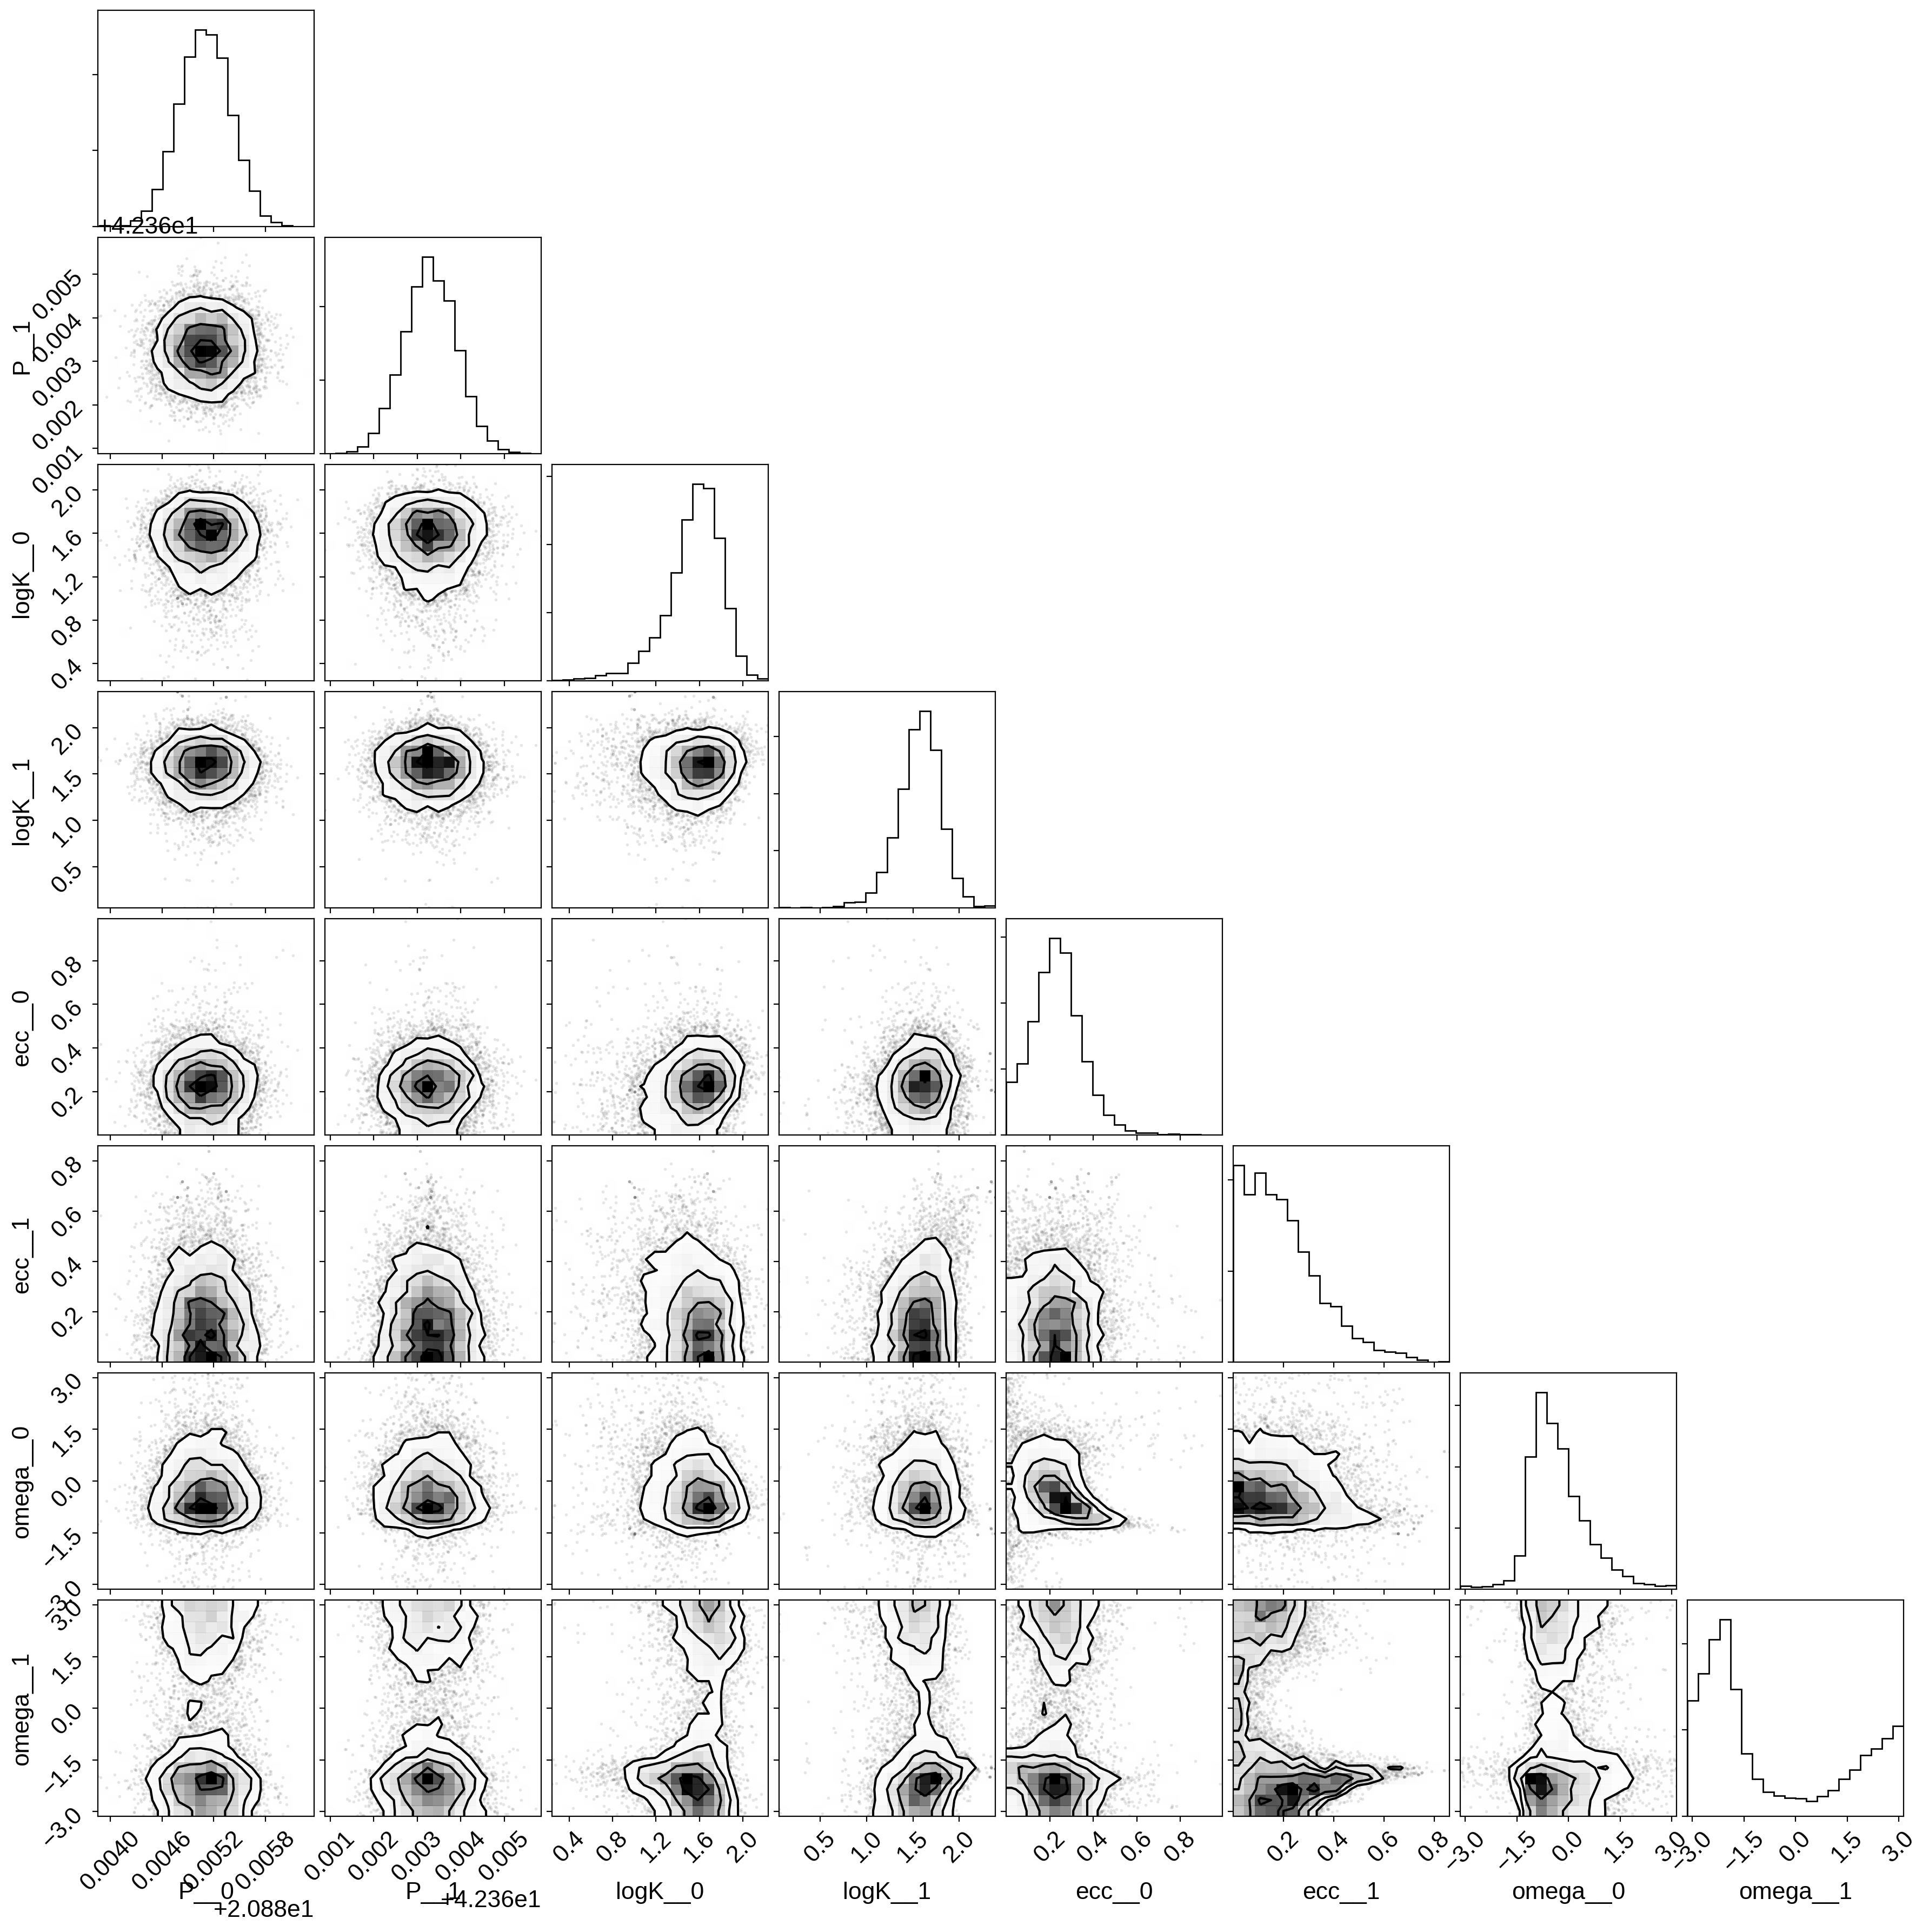

In [11]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc", "omega"])
_ = corner.corner(samples)

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

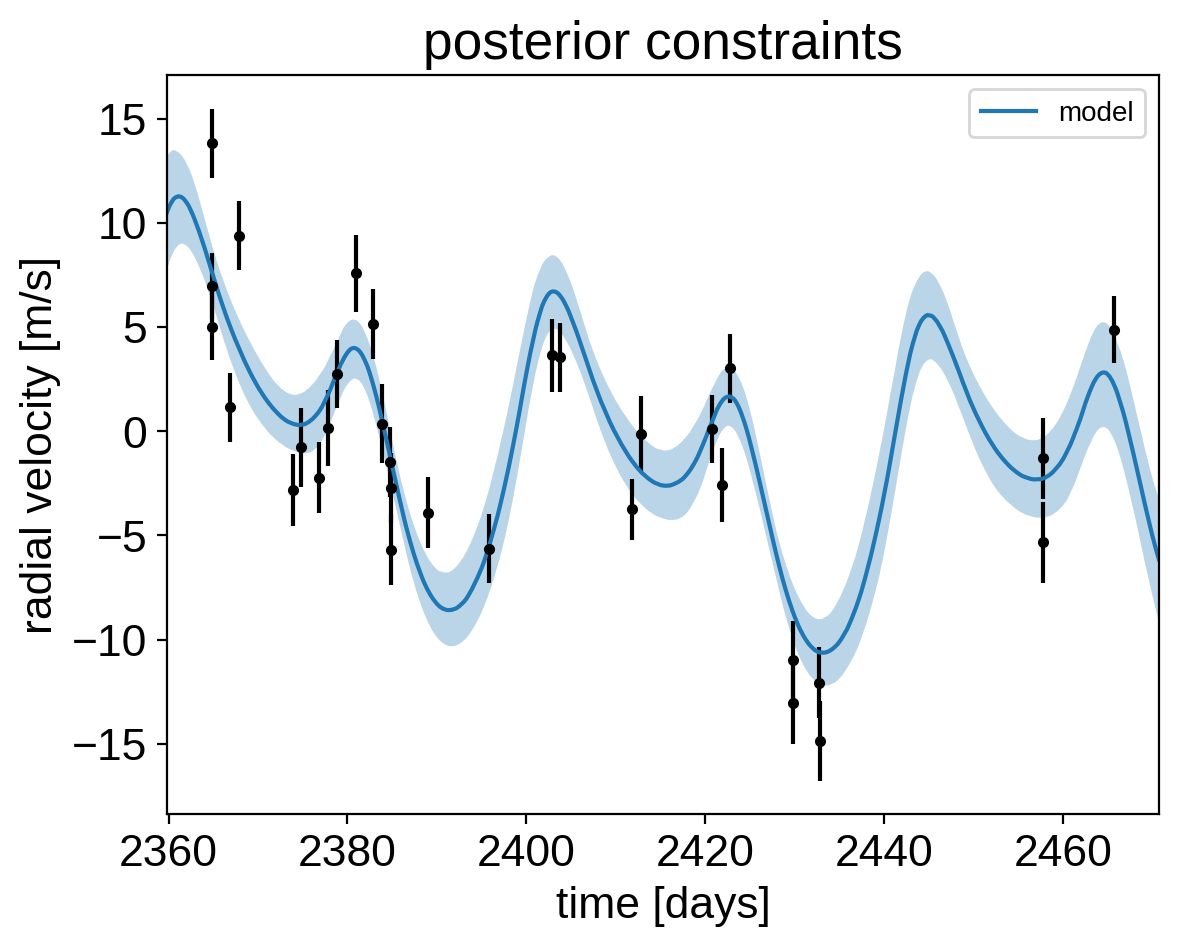

In [12]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

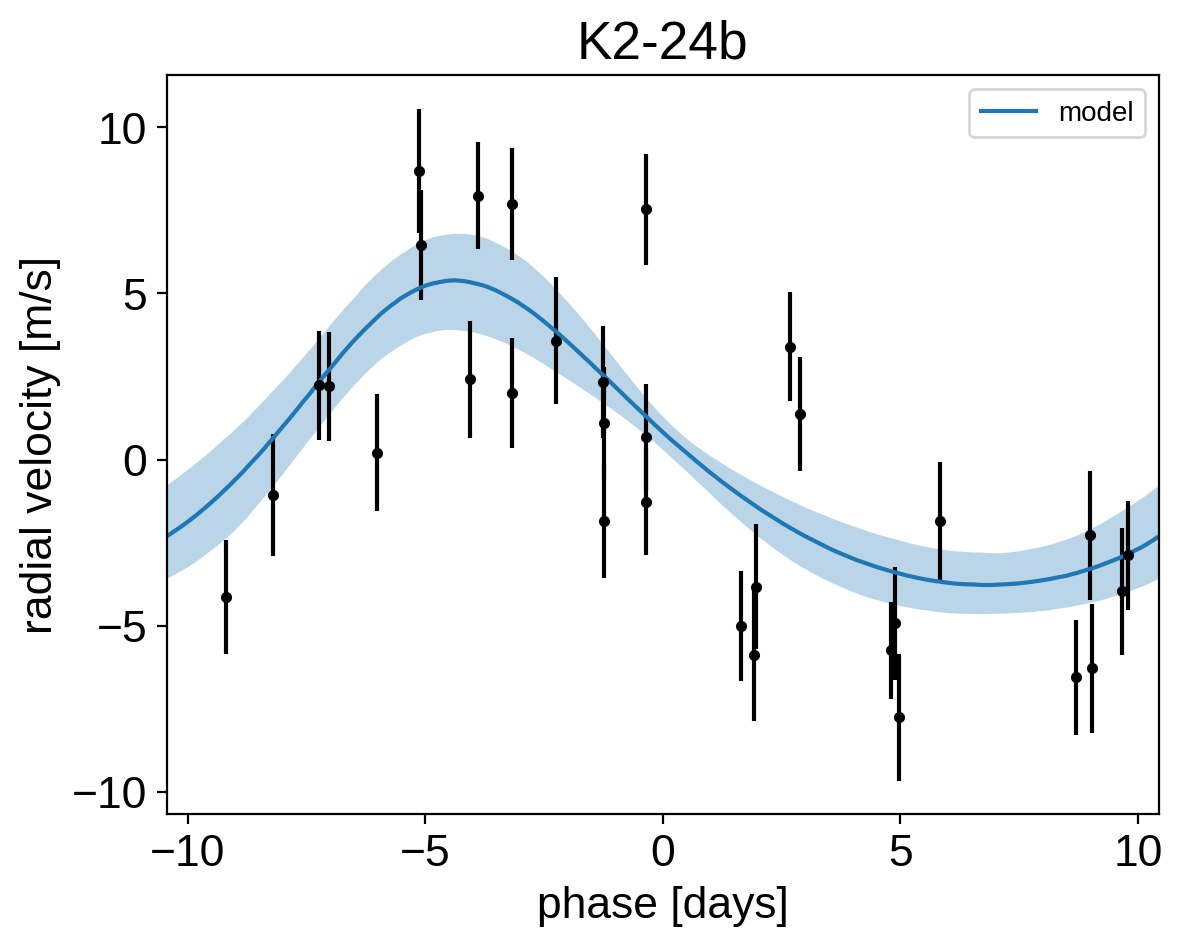

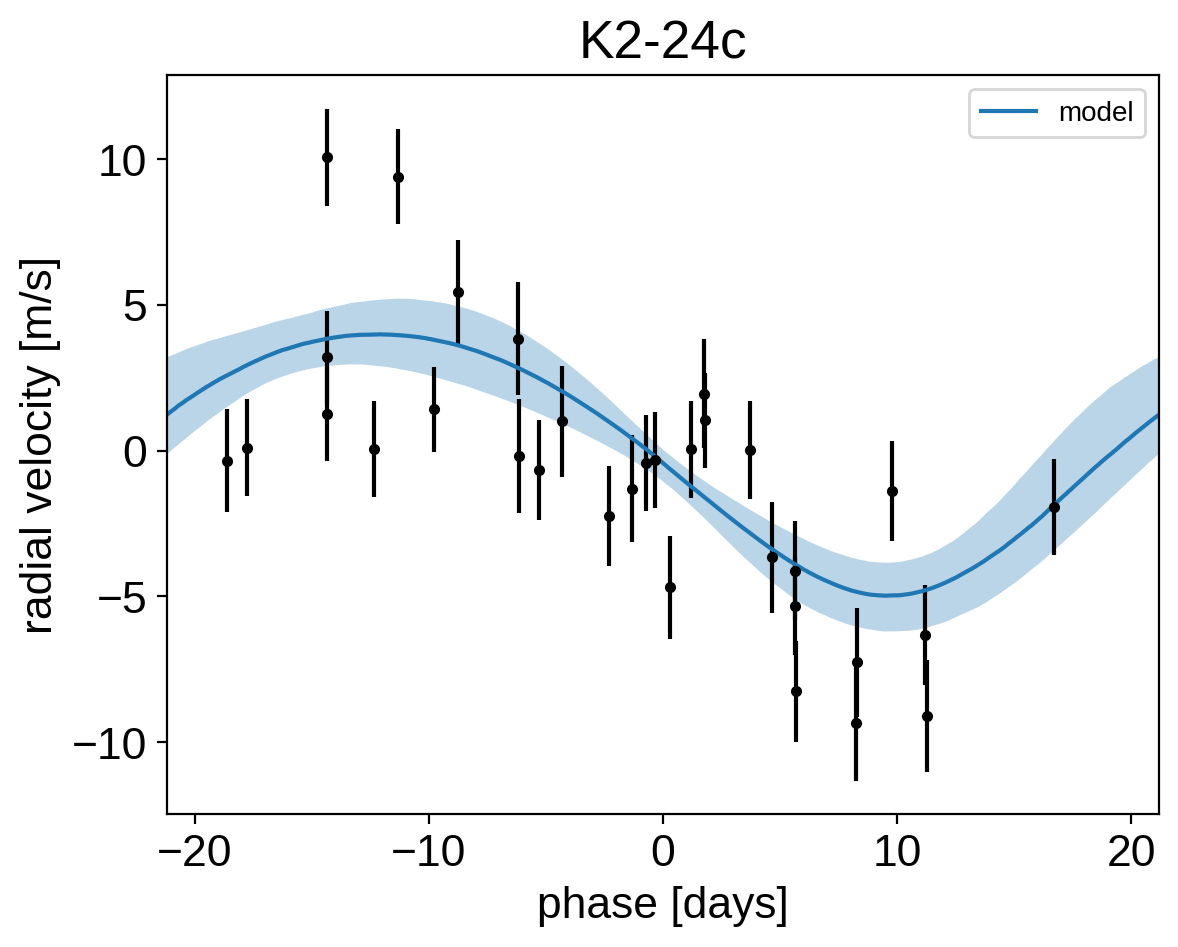

In [13]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [15]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.6},
   month = mar,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
